In [296]:
### imports
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd

from glob import glob
from pathlib import Path
from os import stat
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
from Bio import AlignIO
import matplotlib.font_manager as fm
from scipy import stats

from collections import Counter

%matplotlib inline

plt.rcParams["font.family"] = "Arial"

sns.set(style="whitegrid",
        font_scale=1.5)

pred_dic = {
    "TN": "True negatives",
    "FP": "False positives",
    "FN": "False negatives",
    "TP": "True positives"
}

In [2]:
## output directories
Path("figures/baseline").mkdir(parents=True, exist_ok=True)

In [533]:
### functions
def parse_site_omegas(control_file):
    with open(control_file, "r") as f:
        lines = [line.strip() for line in f.readlines()]
    submodel_i = lines.index("[submodel]")
    classes = [float(i) for i in lines[submodel_i + 3].split(" ")]
    class_dic = {}
    for i in [0, 1, 2]:
        class_dic[i] = classes[i]
    return class_dic


def determine_true_omegas(clustal_align, true_align, true_classes):
    all_omegas = []
    for i_seq, true_seq in enumerate(true_align):
        alt_run = 0
        clustal_codons = clustal_align[i_seq]
        omegas = []
        for i_cod, codon in enumerate(true_seq):
            if codon == "---":
                continue
            while clustal_codons[alt_run] == "---":
                alt_run += 1
                omegas.append(np.nan)
            else:
                assert codon == clustal_codons[alt_run]
                omegas.append(true_classes[i_cod])
                alt_run += 1
        if len(omegas) != len(clustal_align[i_seq]):
            to_gap = len(clustal_align[i_seq]) - len(omegas)
            for i in range(to_gap):
                omegas.append(np.nan)
        all_omegas.append(omegas)
    return np.asarray(all_omegas)


def determine_true_sites(clustal_align, true_align, true_classes):
    all_site_classes = []
    for i_seq, true_seq in enumerate(true_align):
        alt_run = 0
        clustal_codons = clustal_align[i_seq]
        site_classes = []
        for i_cod, codon in enumerate(true_seq):
            if codon == "---":
                continue
            while clustal_codons[alt_run] == "---":
                alt_run += 1
                site_classes.append(3)
            else:
                assert codon == clustal_codons[alt_run]
                site_classes.append(true_classes[i_cod])
                alt_run += 1
        if len(site_classes) != len(clustal_align[i_seq]):
            to_gap = len(clustal_align[i_seq]) - len(site_classes)
            for i in range(to_gap):
                site_classes.append(3)
        site_classes = sum(zip(site_classes,site_classes,site_classes), ())
        all_site_classes.append(site_classes)
    return np.asarray(all_site_classes)


def determine_true_alignment_sites(clustal_align, true_align, true_classes):
    all_site_classes = []
    for i_seq, true_seq in enumerate(true_align):
        clustal_codons = clustal_align[i_seq]
        site_classes = []
        for i_cod, codon in enumerate(true_seq):
            if codon == "---":
                site_classes.append(3)
                continue
            else:
                site_classes.append(true_classes[i_cod])
#         if len(site_classes) != len(clustal_align[i_seq]):
#             to_gap = len(clustal_align[i_seq]) - len(site_classes)
#             for i in range(to_gap):
#                 site_classes.append(3)
        site_classes = sum(zip(site_classes,site_classes,site_classes), ())
        all_site_classes.append(site_classes)
    return np.asarray(all_site_classes)


def parse_site_classes(fi, class_dic):
    with open(fi, "r") as f:
        site_lines = [line.strip() for line in f.readlines()]
    site_lines = site_lines[site_lines.index("Site\tClass\tPartition\tInserted?")+1:]
    site_omegas = [class_dic[int(i.split("\t")[1])] for i in site_lines]
    site_classes = [int(i.split("\t")[1]) for i in site_lines]
    return site_omegas, site_classes

def parse_align_sequence(fi):
    fas = AlignIO.read(fi, "fasta")
    seq_list = []
    for record in fas:
        seq = str(record.seq)
        chunks, chunk_size = len(seq), 3
        seq = [seq[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
        seq_list.append(seq)
    return seq_list


def parse_alignment(file_name):
    # discard alignment if entirely deleted
    if stat(file_name).st_size == 0:
        print("returning all delete")
        return None
    encoding = {"-": [1, 0, 0, 0, 0],
                "A": [0, 1, 0, 0, 0],
                "C": [0, 0, 1, 0, 0],
                "G": [0, 0, 0, 1, 0],
                "T": [0, 0, 0, 0, 1]}
    x_seqs = []
    lines_read = 0
    with open(str(file_name), "r") as file:
        sequence = []
        for line in file:
            if line[0] == ">" and lines_read != 0:
                # discard alignment if entirely deleted
                if len(sequence) < 100:
                    print("returning none")
                    return None
                x_seqs.append(np.asarray(sequence, dtype=np.float32))
                sequence = []
            elif line[0].isalpha() or line[0] == "-":
                for char in line.rstrip("\n"):
                    sequence.append(encoding[char])
            lines_read += 1
        x_seqs.append(np.asarray(sequence, dtype=np.float32))
    x_seqs = tf.convert_to_tensor(x_seqs)
    return x_seqs


def get_label(label_file):
    with open(label_file, "r") as y_fi:
        if y_fi.read(1) == "1":
            return 1
        else:
            return 0


def saliency(model, x):
    # calculate saliency
    y_pred = model.predict(x)

    alignment_tensor = tf.Variable(x, dtype=float)
    with tf.GradientTape() as tape:
        pred = model(alignment_tensor, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, alignment_tensor)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    return grad_eval


def codon_class_saliency(true_clustal_classes, sorted_site_omegas, grad_eval, y_lab, y_pred, saliency_bins):
    pred_y = round(y_pred[0][0])
    saliency_dic = defaultdict(float)
    n_of_sites = defaultdict(int)
    
    bins = np.arange(0,1.1,0.1)
    centers = (bins[1:]+bins[:-1])/2
    # x = np.array([6.68, 9.20, 12.5, 18.75, 21.59])
    # res = bins[np.digitize(x, centers)]
    
    total_saliency = 0
    
    for species in range(len(true_clustal_classes)):
        for i_codon, codon in enumerate(true_clustal_classes[species]):
            total_saliency += grad_eval[species][i_codon]
            # nan = gap
            if np.isnan(codon):
                codon = "3.0"
                saliency_dic[codon] += grad_eval[species][i_codon] # 3.0 = gaps
                n_of_sites[codon] += 1
            else:
                saliency_dic[str(codon)] += grad_eval[species][i_codon]
                n_of_sites[str(codon)] += 1
            # place saliency into bin
            sal_bin = bins[np.digitize(grad_eval[species][i_codon], centers)]
            if y_lab == pred_y:
                if y_lab == 1:
                    saliency_bins["TP"][sal_bin].append(int(codon))
                else:
                    saliency_bins["TN"][sal_bin].append(int(codon))
            elif y_lab != pred_y:
                if y_lab == 1:
                    saliency_bins["FN"][sal_bin].append(int(codon))
                else:
                    saliency_bins["FP"][sal_bin].append(int(codon))
                
    saliency_median_dic = {}
    for k, v in saliency_dic.items():
        saliency_median_dic[str(k) + "median"] = np.median(saliency_dic[k])
    for k, v in saliency_dic.items():
        saliency_dic[k] /= n_of_sites[k]
    for k, v in saliency_median_dic.items():
        saliency_dic[k] = v
    saliency_dic["true_y"] = y_lab
    saliency_dic["pred_y"] = pred_y
    if y_lab == pred_y:
        if y_lab == 1:
            saliency_dic["prediction"] = "TP"
        else:
            saliency_dic["prediction"] = "TN"
    elif y_lab != pred_y:
        if y_lab == 1:
            saliency_dic["prediction"] = "FN"
        else:
            saliency_dic["prediction"] = "FP"
    for i in [0,1,2]:
        try:
            saliency_dic["omega_{}".format(i)] = sorted_site_omegas[i]
        except IndexError:
            saliency_dic["omega_{}".format(i)] = np.nan
    saliency_dic["total_saliency"] = total_saliency
    for k, v in n_of_sites.items():
        saliency_dic[str(k) + "_n_sites"] = v
    return saliency_dic, saliency_bins

In [4]:
### load and initialise model
model = tf.keras.models.load_model("saved_models/2020-12-06-10-15-20_baseline_0.2_average_0.5_512_0.001/50")
x = tf.ones((512, 8, 2000, 5))
model.evaluate(x)

16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00 - auc: 0.0000e+00


[0.0, 0.0, 0.0]

In [4]:
# ### load model with linear final layer
# import os
# import tempfile

# model = tf.keras.models.load_model("saved_models/2020-12-06-10-15-20_baseline_0.2_average_0.5_512_0.001/50")
# model.layers[-1].activation = tf.keras.activations.linear
# model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
# try:
#     model.save(model_path)
#     model = tf.keras.models.load_model(model_path)
# finally:
#     os.remove(model_path)
# assert model.layers[-1].activation == tf.keras.activations.linear

In [208]:
# ### load and initialise model for 64 tips
# model = tf.keras.models.load_model("saved_models/2020-12-21-17-30-08_tips_64_average_0.5_512_0.001/50")
# x = tf.ones((512, 64, 2000, 5))
# model.evaluate(x)

16/16 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00 - auc: 0.0000e+00


[0.0, 0.0, 0.0]

In [14]:
# ### define file lists
# clustal_align, true_align, true_sites, controls, y_fis = [], [], [], [], []

# for t in test_groups:
#     aligns = glob(test_folder + "/clustal_test_x/*fas")
#     for a in aligns:
#         fas_id = a.split("/")[-1].split(".")[0]
#         prefix = "/".join(a.split("/")[:-2])
#         clustal_align.append(a)
#         true_align.append(prefix + "/reference/output_TRUE/dna_TRUE_{}.fas".format(fas_id))
#         true_sites.append(prefix + "/reference/site_classes/dna_RATES_{}.txt".format(fas_id))
#         controls.append(prefix + "/reference/controlFiles/control_{}.txt".format(fas_id))
#         y_fis.append(prefix + "/test_y/{}.txt".format(fas_id))

In [569]:
def process_bayes(fi):
    with open(fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]
    return lines


def process_bayes_df(bayes_fi):
    bayes_df = pd.DataFrame()
    b = process_bayes(bayes_fi)
    # +6 gives first occurrence of a positively selected nt. probability
    indices = [i+6 for i, x in enumerate(b) if x == "Bayes Empirical Bayes (BEB) analysis (Yang, Wong & Nielsen 2005. Mol. Biol. Evol. 22:1107-1118)"]
    model_dic = {}

    for test_comp, i in enumerate(indices):
        if test_comp == 0:
            model_n = "m2"
        else:
            model_n = "m7"
        positions, probs, omega_ests, omega_ses, sigs = [], [], [], [], []
        check = b[i:]
        for val in check:
            if val == "":
                break
            # ['6', 'D', '0.804', '2.506', '+-', '0.899']
            beb_row = val.split()
            positions.append(int(beb_row[0]))
            prob = float(beb_row[2].replace("*",""))
            probs.append(prob) # * characters included for p>=0.95
            omega_ests.append(float(beb_row[3]))
            omega_ses.append(float(beb_row[5]))
            if prob >= 0.99:
                sigs.append(2)
            elif prob >= 0.95:
                sigs.append(1)
            else:
                sigs.append(0)
        model_dic["{}_positions".format(model_n)] = positions
        model_dic["{}_probs".format(model_n)] = probs
        model_dic["{}_omega_ests".format(model_n)] = omega_ests
        model_dic["{}_omega_ses".format(model_n)] = omega_ses
        model_dic["{}_sigs".format(model_n)] = sigs

    bayes_df = bayes_df.append(model_dic, ignore_index=True)
    return bayes_df


def process_logs(log_fi):
    with open(log_fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]
    insertions, deletions, ins_len, del_len = 0, 0, 0.0, 0.0
    for line in lines:
        if line.startswith("Number of insertion events"):
            insertions = int(line.split()[-1])
        if line.startswith("Number of deletion events"):
            deletions = int(line.split()[-1])
        if line.startswith("Actual average insertion length"):
            ins_len = float(line.split()[-1])
        if line.startswith("Actual average deletion length"):
            del_len = float(line.split()[-1])
    return insertions, deletions, ins_len, del_len


def process_params(param_fi):
    with open(param_fi, "r") as f:
        lines = [i.strip() for i in f.readlines()]
    return int(lines[-2])

In [6]:
### define file lists
test_folder = "/hps/nobackup/research/goldmans/conor/omega_ai/paml_selection/determining_branch_lengths/output/0.2"
clustal_align, true_align, true_sites, controls, y_fis, bayes, logs, params = [], [], [], [], [], [], [], []

# for t in test_groups:
aligns = glob(test_folder + "/clustal_test_x/*fas")
for a in aligns:
    fas_id = a.split("/")[-1].split(".")[0]
    prefix = "/".join(a.split("/")[:-2])
    clustal_align.append(a)
    true_align.append(prefix + "/true_test_x/{}.fas".format(fas_id))
    true_sites.append(prefix + "/reference/site_classes/dna_RATES_{}.txt".format(fas_id))
    controls.append(prefix + "/reference/controlFiles/control_{}.txt".format(fas_id))
    bayes.append(prefix + "/reference/PAML_output/clustal/{}.out".format(fas_id))
    logs.append(prefix + "/reference/LOG/LOG_{}.txt".format(fas_id))
    params.append(prefix + "/reference/parameters/{}.txt".format(fas_id))
    y_fis.append(prefix + "/test_y/{}.txt".format(fas_id))

In [8]:
### define file lists for 64 tips
test_folder = "/hps/nobackup/research/goldmans/conor/omega_ai/paml_selection/paml_test_sets/output/64_tips"
clustal_align, true_align, true_sites, controls, y_fis, bayes, logs, params = [], [], [], [], [], [], [], []

# for t in test_groups:
aligns = glob(test_folder + "/clustal_test_x/*fas")
for a in aligns:
    fas_id = a.split("/")[-1].split(".")[0]
    prefix = "/".join(a.split("/")[:-2])
    clustal_align.append(a)
    true_align.append(prefix + "/true_test_x/{}.fas".format(fas_id))
    true_sites.append(prefix + "/reference/site_classes/dna_RATES_{}.txt".format(fas_id))
    controls.append(prefix + "/reference/controlFiles/control_20_{}.txt".format(fas_id))
    bayes.append(prefix + "/reference/PAML_output/clustal/{}.out".format(fas_id))
    logs.append(prefix + "/reference/LOG/LOG_{}.txt".format(fas_id))
    params.append(prefix + "/reference/parameters/{}.txt".format(fas_id))
    y_fis.append(prefix + "/test_y/20_{}.txt".format(fas_id))

In [7]:
def lambda_max(arr, axis=None, key=None, keepdims=False):
    if callable(key):
        idxs = np.argmax(key(arr), axis)
        if axis is not None:
            idxs = np.expand_dims(idxs, axis)
            result = np.take_along_axis(arr, idxs, axis)
            if not keepdims:
                result = np.squeeze(result, axis=axis)
            return result
        else:
            return arr.flatten()[idxs]
    else:
        return np.amax(arr, axis)

In [96]:
len(clustal_align)

2170

In [531]:
for i in [33]:
    x = parse_alignment(clustal_align[i])
    padding = 0
    
    x = tf.keras.preprocessing.sequence.pad_sequences(
                x,
                padding="post",
                value=0,
                maxlen=2000,
                dtype="float32")
    y = get_label(y_fis[i])
    site_omegas, site_classes = parse_site_classes(true_sites[i], parse_site_omegas(controls[i]))

    parsed_true = parse_align_sequence(true_align[i])
    parsed_clustal = parse_align_sequence(clustal_align[i])
    
    true_clustal_omegas = determine_true_omegas(parsed_clustal, parsed_true, site_omegas)
    true_clustal_classes = determine_true_sites(parsed_clustal, parsed_true, site_classes)
    true_classes = determine_true_alignment_sites(parsed_true, parsed_true, site_classes)

    x = np.expand_dims(x, axis=0)

    x = tf.convert_to_tensor(x, dtype="float32")
    
    q = model.predict(x)
    # y_pred = model.predict(x)

    alignment_tensor = tf.Variable(x, dtype=float)
    with tf.GradientTape() as tape:
        tape.watch(alignment_tensor)
        pred = model(alignment_tensor, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, alignment_tensor)
    #gradient = tf.reduce_max(gradient, axis=-1)
    #gradient = gradient.numpy()
    
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(grads, axis=3)[0]
#     print(np.max(grads, axis=3)[0].shape)
#     print(np.argmax(grads, axis=3)[0].shape)

    #dgrad_max_ = grads[0][np.argmax(grads, axis=3)[0]]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    #min_val, max_val = np.min(gradient), np.max(gradient)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    #gradient = (gradient - min_val) / (max_val - min_val + 1e-18)
    codon_saliency_dic, saliency_bins = codon_class_saliency(true_clustal_classes, sorted(set(site_omegas)), grad_eval, y, q, saliency_bins)

2 843
0 5436
1 3060
3 1989


In [540]:
codon_saliency_dic

defaultdict(float,
            {'3': 0.020605754095013848,
             '0': 0.028550657651088687,
             '1': 0.02964355933002053,
             '2': 0.10324541557289607,
             '3median': 40.42848953441717,
             '0median': 182.09609449864365,
             '1median': 89.01960866805166,
             '2median': 72.78801797889173,
             'true_y': 1,
             'pred_y': 1,
             'prediction': 'TP',
             'omega_0': 0.43235838701226836,
             'omega_1': 0.6672113465543421,
             'omega_2': 2.3728403687681645,
             'total_saliency': 384.3322106800042,
             '3_n_sites': 1962,
             '0_n_sites': 6378,
             '1_n_sites': 3003,
             '2_n_sites': 705,
             'true_clustal_classes': array([[3, 3, 3, ..., 0, 0, 0],
                    [3, 3, 3, ..., 0, 0, 0],
                    [0, 0, 0, ..., 0, 0, 0],
                    ...,
                    [3, 3, 3, ..., 0, 0, 0],
                    [1, 1,

In [563]:
df = df[df["3"] != 0]

In [198]:
len(set(grad_eval[0]))

1

<AxesSubplot:>

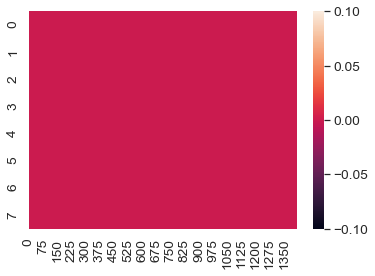

In [161]:
sns.heatmap(grad_eval)

In [534]:
### process alignments into saliency maps
df = pd.DataFrame()
bayes_df = pd.DataFrame()

# track classes in saliency bins
saliency_bins = {}
for i in ["TP", "TN", "FN", "FP"]:
    saliency_bins[i] = defaultdict(list)


for i in range(len(clustal_align)):
    y = get_label(y_fis[i])

    site_omegas, site_classes = parse_site_classes(true_sites[i], parse_site_omegas(controls[i]))
    parsed_true = parse_align_sequence(true_align[i])
    parsed_clustal = parse_align_sequence(clustal_align[i])
    true_clustal_omegas = determine_true_omegas(parsed_clustal, parsed_true, site_omegas)
    true_clustal_classes = determine_true_sites(parsed_clustal, parsed_true, site_classes)
    true_classes = determine_true_alignment_sites(parsed_true, parsed_true, site_classes)
    
    # process x
    x = parse_alignment(clustal_align[i])
    padding = 0
    if x.shape[1] < 1200:
        x = tf.keras.preprocessing.sequence.pad_sequences(
            x,
            padding="post",
            value=0,
            maxlen=1200,
            dtype="float32")
        
    x = np.expand_dims(x, axis=0)
    x = tf.convert_to_tensor(x, dtype="float32")
    q = model.predict(x)
    alignment_tensor = tf.Variable(x, dtype=float)
    with tf.GradientTape() as tape:
        pred = model(alignment_tensor, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
    grads = tape.gradient(loss, alignment_tensor)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(grads, axis=3)[0]
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    
    if len(set(grad_eval[0])) == 1:
        x = parse_alignment(clustal_align[i])
        x = tf.keras.preprocessing.sequence.pad_sequences(
            x,
            padding="post",
            value=0,
            maxlen=4000,
            dtype="float32")
        x = np.expand_dims(x, axis=0)
        x = tf.convert_to_tensor(x, dtype="float32")
        q = model.predict(x)
        alignment_tensor = tf.Variable(x, dtype=float)
        with tf.GradientTape() as tape:
            pred = model(alignment_tensor, training=False)
            class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
            loss = pred[0][class_idxs_sorted[0]]
        grads = tape.gradient(loss, alignment_tensor)
        dgrad_abs = tf.math.abs(grads)
        dgrad_max_ = np.max(grads, axis=3)[0]
        arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
        grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    
    
    codon_saliency_dic, saliency_bins = codon_class_saliency(true_clustal_classes, sorted(set(site_omegas)), grad_eval, y, q, saliency_bins)
    codon_saliency_dic["true_clustal_classes"] = true_clustal_classes
    codon_saliency_dic["true_true_classes"] = true_classes
    codon_saliency_dic["saliency_map"] = grad_eval
    codon_saliency_dic["fasta_path"] = clustal_align[i]
    codon_saliency_dic["padding"] = padding
    codon_saliency_dic["normalised_total_saliency"] = codon_saliency_dic["total_saliency"] / grad_eval.size
    codon_saliency_dic["insertions"], codon_saliency_dic["deletions"], codon_saliency_dic["ins_len"], codon_saliency_dic["del_len"] = process_logs(logs[i])
    codon_saliency_dic["root_length"] = process_params(params[i])
    df = df.append(codon_saliency_dic, ignore_index=True)
    bayes_df = bayes_df.append(process_bayes_df(bayes[i]), ignore_index=True)
    bayes_df["prediction"] = df["prediction"]
    tp_bayes_df = bayes_df[bayes_df["prediction"] == "TP"]


tp_df = df[df["prediction"] == "TP"]
fp_df = df[df["prediction"] == "FP"]
no_zero_df = df[df["omega_2"] != 0]

In [535]:
list(df)

['0',
 '0_n_sites',
 '0median',
 '1',
 '1_n_sites',
 '1median',
 '2',
 '2_n_sites',
 '2median',
 '3',
 '3_n_sites',
 '3median',
 'del_len',
 'deletions',
 'fasta_path',
 'ins_len',
 'insertions',
 'normalised_total_saliency',
 'omega_0',
 'omega_1',
 'omega_2',
 'padding',
 'pred_y',
 'prediction',
 'root_length',
 'saliency_map',
 'total_saliency',
 'true_clustal_classes',
 'true_true_classes',
 'true_y']

<AxesSubplot:xlabel='clustal_lengths', ylabel='root_length'>

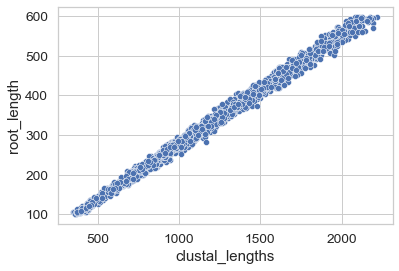

In [456]:
sns.scatterplot(data=df,
            x="clustal_lengths",
            y="root_length")

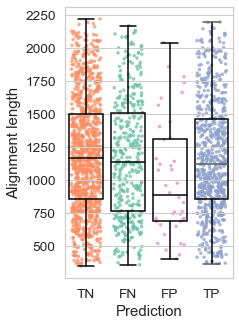

In [487]:
fig, ax = plt.subplots(figsize=(3,5))

tp_fn_pal = [sns.color_palette("Set2")[1],
             sns.color_palette("Set2")[0],
             sns.color_palette("Set2")[3],
             sns.color_palette("Set2")[2]]

sns.boxplot(data=df,
            x="prediction",
            y="clustal_lengths",
            palette=tp_fn_pal)
                      
sns.stripplot(data=df,
              x="prediction",
              y="clustal_lengths",
              palette=tp_fn_pal,
              alpha=.75,
              zorder=0,
              jitter=.35,
              size=3.5)
                      

for art_i, artist in enumerate(ax.artists):
    col1 = artist.get_facecolor()
    col = "black"

    r, g, b, a = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor((r, g, b, 0))
    for j in range(art_i*5,art_i*5+5):
        line = ax.lines[j]
        line.set_color(col)
        
ax.set_xlabel("Prediction")
ax.set_ylabel("Alignment length")

plt.savefig("figures/baseline/alignment_lengths.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

In [539]:
df

,0,0_n_sites,0median,1,1_n_sites,1median,2,2_n_sites,2median,3,...,omega_2,padding,pred_y,prediction,root_length,saliency_map,total_saliency,true_clustal_classes,true_true_classes,true_y
0,0.025482,5475.0,139.512447,0.026065,2133.0,55.596256,0.028072,396.0,11.116642,0.017552,...,0.980570,0.0,0.0,TN,331.0,"[[0.020849688, 0.0119133275, 0.02095921, 0.026...",231.711205,"[[3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",0.0
1,0.039020,9141.0,356.679841,0.053618,3372.0,180.800604,0.108333,126.0,13.649930,0.026915,...,0.989284,0.0,0.0,TN,523.0,"[[0.012633781, 0.012453016, 0.013380887, 0.011...",617.906073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0
2,0.027005,2886.0,77.936791,0.024421,1959.0,47.840686,0.125551,465.0,58.381389,0.019249,...,2.471407,0.0,0.0,FN,218.0,"[[0.009249419, 0.0089286165, 0.008297089, 0.01...",205.756555,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",1.0
3,0.066966,5247.0,351.372109,0.085469,3024.0,258.459120,0.083192,1050.0,87.352042,0.053012,...,0.907350,0.0,0.0,TN,394.0,"[[0.033110116, 0.032960285, 0.033001125, 0.031...",804.851461,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,...",0.0
4,0.017283,4107.0,70.982654,0.021493,3288.0,70.668500,0.061021,378.0,23.065969,0.013397,...,0.992764,0.0,0.0,TN,328.0,"[[0.009101709, 0.0085267, 0.008669624, 0.00751...",190.157619,"[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","[[0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3,...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.035333,6288.0,222.175194,0.044438,2418.0,107.451796,0.082622,360.0,29.743864,0.030403,...,0.957023,0.0,0.0,TN,378.0,"[[0.021191366, 0.020897213, 0.02089654, 0.0226...",415.737505,"[[3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0,...","[[0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,...",0.0
2166,0.034515,6228.0,214.956441,0.031191,927.0,28.914468,0.098162,348.0,34.160380,0.023177,...,0.906325,0.0,0.0,TN,321.0,"[[0.01849643, 0.01834737, 0.014525836, 0.01597...",309.389112,"[[3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3,...",0.0
2167,0.032560,4824.0,157.067421,0.033825,2010.0,67.988446,0.106691,174.0,18.564267,0.025785,...,4.177791,0.0,1.0,TP,297.0,"[[0.014769905, 0.012427328, 0.0150213335, 0.01...",276.418160,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,...","[[3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3,...",1.0
2168,0.049873,4881.0,243.432516,0.075600,2454.0,185.521487,0.077226,492.0,37.995427,0.041850,...,0.986075,0.0,0.0,TN,324.0,"[[0.021652097, 0.019364022, 0.016025808, 0.031...",533.114950,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0


In [541]:
list(df)

['0',
 '0_n_sites',
 '0median',
 '1',
 '1_n_sites',
 '1median',
 '2',
 '2_n_sites',
 '2median',
 '3',
 '3_n_sites',
 '3median',
 'del_len',
 'deletions',
 'fasta_path',
 'ins_len',
 'insertions',
 'normalised_total_saliency',
 'omega_0',
 'omega_1',
 'omega_2',
 'padding',
 'pred_y',
 'prediction',
 'root_length',
 'saliency_map',
 'total_saliency',
 'true_clustal_classes',
 'true_true_classes',
 'true_y']

In [542]:
for i in [0,1,2,3]:
#     df["{}_length_normalised".format(i)] = df["{}".format(i)] / df["clustal_lengths"]
#     df["deletion_normalised".format(i)] = df["deletions"] / df["clustal_lengths"]
#     df["insertions_normalised".format(i)] = df["deletions"] / df["clustal_lengths"]
    df["{}_n_sites_normalised".format(i)] = df["{}_n_sites".format(i)] / (df["0_n_sites"]+df["1_n_sites"]+df["2_n_sites"]+df["3_n_sites"])

In [543]:
df

,0,0_n_sites,0median,1,1_n_sites,1median,2,2_n_sites,2median,3,...,root_length,saliency_map,total_saliency,true_clustal_classes,true_true_classes,true_y,0_n_sites_normalised,1_n_sites_normalised,2_n_sites_normalised,3_n_sites_normalised
0,0.025482,5475.0,139.512447,0.026065,2133.0,55.596256,0.028072,396.0,11.116642,0.017552,...,331.0,"[[0.020849688, 0.0119133275, 0.02095921, 0.026...",231.711205,"[[3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",0.0,0.578997,0.225571,0.041878,0.153553
1,0.039020,9141.0,356.679841,0.053618,3372.0,180.800604,0.108333,126.0,13.649930,0.026915,...,523.0,"[[0.012633781, 0.012453016, 0.013380887, 0.011...",617.906073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,0.604563,0.223016,0.008333,0.164087
2,0.027005,2886.0,77.936791,0.024421,1959.0,47.840686,0.125551,465.0,58.381389,0.019249,...,218.0,"[[0.009249419, 0.0089286165, 0.008297089, 0.01...",205.756555,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",1.0,0.448694,0.304571,0.072295,0.174440
3,0.066966,5247.0,351.372109,0.085469,3024.0,258.459120,0.083192,1050.0,87.352042,0.053012,...,394.0,"[[0.033110116, 0.032960285, 0.033001125, 0.031...",804.851461,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,...",0.0,0.462209,0.266385,0.092495,0.178911
4,0.017283,4107.0,70.982654,0.021493,3288.0,70.668500,0.061021,378.0,23.065969,0.013397,...,328.0,"[[0.009101709, 0.0085267, 0.008669624, 0.00751...",190.157619,"[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","[[0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3,...",0.0,0.424628,0.339950,0.039082,0.196340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.035333,6288.0,222.175194,0.044438,2418.0,107.451796,0.082622,360.0,29.743864,0.030403,...,378.0,"[[0.021191366, 0.020897213, 0.02089654, 0.0226...",415.737505,"[[3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0,...","[[0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,...",0.0,0.575824,0.221429,0.032967,0.169780
2166,0.034515,6228.0,214.956441,0.031191,927.0,28.914468,0.098162,348.0,34.160380,0.023177,...,321.0,"[[0.01849643, 0.01834737, 0.014525836, 0.01597...",309.389112,"[[3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3,...",0.0,0.703252,0.104675,0.039295,0.152778
2167,0.032560,4824.0,157.067421,0.033825,2010.0,67.988446,0.106691,174.0,18.564267,0.025785,...,297.0,"[[0.014769905, 0.012427328, 0.0150213335, 0.01...",276.418160,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,...","[[3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3,...",1.0,0.582609,0.242754,0.021014,0.153623
2168,0.049873,4881.0,243.432516,0.075600,2454.0,185.521487,0.077226,492.0,37.995427,0.041850,...,324.0,"[[0.021652097, 0.019364022, 0.016025808, 0.031...",533.114950,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,0.518814,0.260842,0.052296,0.168048


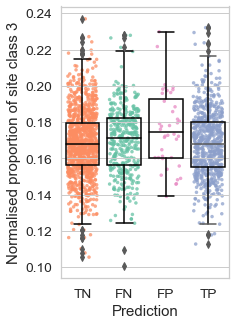

In [554]:
fig, ax = plt.subplots(figsize=(3,5))

tp_fn_pal = [sns.color_palette("Set2")[1],
             sns.color_palette("Set2")[0],
             sns.color_palette("Set2")[3],
             sns.color_palette("Set2")[2]]

var = "3_n_sites_normalised"

sns.boxplot(data=df,
            x="prediction",
            y=var,
            palette=tp_fn_pal)
                      
sns.stripplot(data=df,
              x="prediction",
              y=var,
              palette=tp_fn_pal,
              alpha=.75,
              zorder=0,
              jitter=.35,
              size=3.5)
                      

for art_i, artist in enumerate(ax.artists):
    col1 = artist.get_facecolor()
    col = "black"

    r, g, b, a = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor((r, g, b, 0))
    for j in range(art_i*5,art_i*5+5):
        line = ax.lines[j]
        line.set_color(col)
        
ax.set_xlabel("Prediction")
ax.set_ylabel("Normalised proportion of site class 3")

plt.savefig("figures/baseline/number_of_siteclass2_normalised.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

In [498]:
df

,0,0median,1,1median,2,2median,3,3median,del_len,deletions,...,2_length_normalised,3_length_normalised,0_deletion_normalised,0_insertions_normalised,1_deletion_normalised,1_insertions_normalised,2_deletion_normalised,2_insertions_normalised,3_deletion_normalised,3_insertions_normalised
0,0.025482,139.512447,0.026065,55.596256,0.028072,11.116642,0.017552,25.485859,1.68966,87.0,...,0.000024,0.000015,0.073604,0.073604,0.073604,0.073604,0.073604,0.073604,0.073604,0.073604
1,0.039020,356.679841,0.053618,180.800604,0.108333,13.649930,0.026915,66.775699,1.48000,150.0,...,0.000057,0.000014,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365
2,0.027005,77.936791,0.024421,47.840686,0.125551,58.381389,0.019249,21.597690,1.59016,61.0,...,0.000156,0.000024,0.075871,0.075871,0.075871,0.075871,0.075871,0.075871,0.075871,0.075871
3,0.066966,351.372109,0.085469,258.459120,0.083192,87.352042,0.053012,107.668190,1.50413,121.0,...,0.000059,0.000037,0.085271,0.085271,0.085271,0.085271,0.085271,0.085271,0.085271,0.085271
4,0.017283,70.982654,0.021493,70.668500,0.061021,23.065969,0.013397,25.440495,1.63636,88.0,...,0.000050,0.000011,0.072787,0.072787,0.072787,0.072787,0.072787,0.072787,0.072787,0.072787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.035333,222.175194,0.044438,107.451796,0.082622,29.743864,0.030403,56.366652,1.58182,110.0,...,0.000061,0.000022,0.080586,0.080586,0.080586,0.080586,0.080586,0.080586,0.080586,0.080586
2166,0.034515,214.956441,0.031191,28.914468,0.098162,34.160380,0.023177,31.357823,1.63265,98.0,...,0.000089,0.000021,0.088528,0.088528,0.088528,0.088528,0.088528,0.088528,0.088528,0.088528
2167,0.032560,157.067421,0.033825,67.988446,0.106691,18.564267,0.025785,32.798027,1.49398,83.0,...,0.000103,0.000025,0.080193,0.080193,0.080193,0.080193,0.080193,0.080193,0.080193,0.080193
2168,0.049873,243.432516,0.075600,185.521487,0.077226,37.995427,0.041850,66.165520,1.50000,74.0,...,0.000066,0.000036,0.062925,0.062925,0.062925,0.062925,0.062925,0.062925,0.062925,0.062925


In [9]:
# ### process alignments into saliency maps
# for i in range(len(clustal_align)):
#     if clustal_align[i] == "/hps/nobackup/research/goldmans/conor/omega_ai/data/simulations/test_datasets/baseline/group_404/clustal_test_x/404.fas":
#         x = parse_alignment(clustal_align[i])

#         x = tf.keras.preprocessing.sequence.pad_sequences(
#             x,
#             padding="post",
#             value=0,
#             maxlen=2000,
#             dtype="float32"
#         )

#         y = get_label(y_fis[i])
#         site_omegas, site_classes = parse_site_classes(true_sites[i], parse_site_omegas(controls[i]))
#         parsed_true = parse_align_sequence(true_align[i])
#         parsed_clustal = parse_align_sequence(clustal_align[i])
#         true_clustal_omegas = determine_true_omegas(parsed_clustal, parsed_true, site_omegas)
#         true_clustal_classes = determine_true_sites(parsed_clustal, parsed_true, site_classes)

#         x = np.expand_dims(x, axis=0)

#         #x = tf.convert_to_tensor(x, dtype="float32")

#         q = model.predict(x)
#         # y_pred = model.predict(x)

#         alignment_tensor = tf.Variable(x, dtype=float)
#         with tf.GradientTape() as tape:
#             pred = model(alignment_tensor, training=False)
#             class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
#             loss = pred[0][class_idxs_sorted[0]]

#         #loss = tf.convert_to_tensor(0, dtype="float32")
#         grads = tape.gradient(loss, alignment_tensor)
#         dgrad_abs = tf.math.abs(grads)
#         dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
#         arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
#         grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

<AxesSubplot:xlabel='prediction', ylabel='deletion_normalised'>

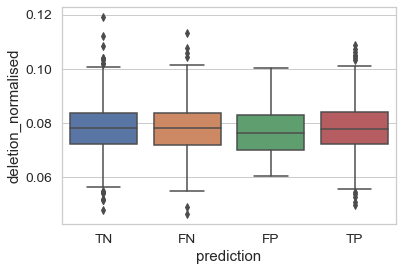

In [511]:
sns.boxplot(data=df,
           x="prediction",
           y="deletion_normalised")

In [437]:
list(pos_df)

['0',
 '1',
 '2',
 '3',
 'align_len',
 'del_len',
 'deletions',
 'ins_len',
 'insertions',
 'omega_0',
 'omega_1',
 'omega_2',
 'prediction',
 'saliency_0',
 'saliency_1',
 'saliency_2',
 'total_deletions',
 'total_insertions',
 'total_saliency',
 'PC1',
 'PC2',
 'PC3',
 'PC4']

Text(0.5, 0, 'Gaps')

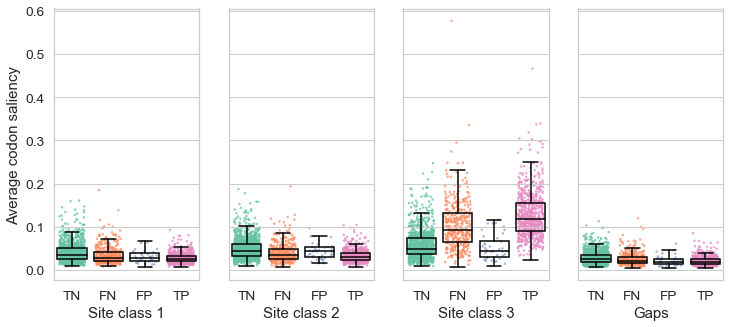

In [210]:
fig, axes = plt.subplots(1,4, figsize=(12,5),
                        sharey=True)

sns.set(font_scale=1.25)


for i in range(4):
    a = sns.boxplot(data=df, y="{}".format(i),
                x="prediction",
                ax=axes[i],
                showfliers = False,
                palette="Set2")
    a = sns.stripplot(data=df, y="{}".format(i),
                x="prediction",
                ax=axes[i],
                alpha=.75,
                zorder=0,
                jitter=.35,
                palette="Set2",
                size=2.5
    )

    for art_i, artist in enumerate(axes[i].artists):
        col1 = artist.get_facecolor()
        col = "black"

        r, g, b, a = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor((r, g, b, 0))
        for j in range(art_i*5,art_i*5+5):
            line = axes[i].lines[j]
            line.set_color(col)
            #line.set_mfc(col1)
            #line.set_mec(col1)
    axes[i].set_xlabel("Site class {}".format(i+1))
    axes[i].set_ylabel("")
axes[0].set_ylabel("Average codon saliency")
sns.set_style("whitegrid")
axes[3].set_xlabel("Gaps")


# plt.savefig("figures/baseline/codon_saliency_boxplots.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

Text(0.5, 0, 'Gaps')

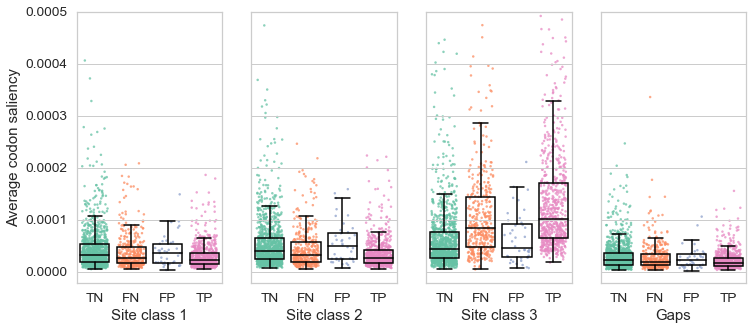

In [496]:
fig, axes = plt.subplots(1,4, figsize=(12,5),
                        sharey=True)

sns.set(font_scale=1.25)


for i in range(4):
    a = sns.boxplot(data=df, y="{}_length_normalised".format(i),
                x="prediction",
                ax=axes[i],
                showfliers = False,
                palette="Set2")
    a = sns.stripplot(data=df, y="{}_length_normalised".format(i),
                x="prediction",
                ax=axes[i],
                alpha=.75,
                zorder=0,
                jitter=.35,
                palette="Set2",
                size=2.5
    )

    for art_i, artist in enumerate(axes[i].artists):
        col1 = artist.get_facecolor()
        col = "black"

        r, g, b, a = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor((r, g, b, 0))
        for j in range(art_i*5,art_i*5+5):
            line = axes[i].lines[j]
            line.set_color(col)
            #line.set_mfc(col1)
            #line.set_mec(col1)
    axes[i].set_xlabel("Site class {}".format(i+1))
    axes[i].set_ylabel("")
    
    axes[i].set_ylim(top=0.0005)

    
axes[0].set_ylabel("Average codon saliency")
sns.set_style("whitegrid")
axes[3].set_xlabel("Gaps")


# plt.savefig("figures/baseline/codon_saliency_boxplots.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [11]:
df["insertion"]

KeyError: 'insertion'

,0,0median,1,1median,2,2median,3,3median,del_len,deletions,...,omega_2,padding,pred_y,prediction,root_length,saliency_map,total_saliency,true_clustal_classes,true_true_classes,true_y
0,0.025482,139.512447,0.026065,55.596256,0.028072,11.116642,0.017552,25.485859,1.68966,87.0,...,0.980570,0.0,0.0,TN,331.0,"[[0.020849688, 0.0119133275, 0.02095921, 0.026...",231.711205,"[[3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",0.0
1,0.039020,356.679841,0.053618,180.800604,0.108333,13.649930,0.026915,66.775699,1.48000,150.0,...,0.989284,0.0,0.0,TN,523.0,"[[0.012633781, 0.012453016, 0.013380887, 0.011...",617.906073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0
2,0.027005,77.936791,0.024421,47.840686,0.125551,58.381389,0.019249,21.597690,1.59016,61.0,...,2.471407,0.0,0.0,FN,218.0,"[[0.009249419, 0.0089286165, 0.008297089, 0.01...",205.756555,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",1.0
3,0.066966,351.372109,0.085469,258.459120,0.083192,87.352042,0.053012,107.668190,1.50413,121.0,...,0.907350,0.0,0.0,TN,394.0,"[[0.033110116, 0.032960285, 0.033001125, 0.031...",804.851461,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,...",0.0
4,0.017283,70.982654,0.021493,70.668500,0.061021,23.065969,0.013397,25.440495,1.63636,88.0,...,0.992764,0.0,0.0,TN,328.0,"[[0.009101709, 0.0085267, 0.008669624, 0.00751...",190.157619,"[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","[[0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3,...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.035333,222.175194,0.044438,107.451796,0.082622,29.743864,0.030403,56.366652,1.58182,110.0,...,0.957023,0.0,0.0,TN,378.0,"[[0.021191366, 0.020897213, 0.02089654, 0.0226...",415.737505,"[[3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0,...","[[0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,...",0.0
2166,0.034515,214.956441,0.031191,28.914468,0.098162,34.160380,0.023177,31.357823,1.63265,98.0,...,0.906325,0.0,0.0,TN,321.0,"[[0.01849643, 0.01834737, 0.014525836, 0.01597...",309.389112,"[[3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","[[3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3,...",0.0
2167,0.032560,157.067421,0.033825,67.988446,0.106691,18.564267,0.025785,32.798027,1.49398,83.0,...,4.177791,0.0,1.0,TP,297.0,"[[0.014769905, 0.012427328, 0.0150213335, 0.01...",276.418160,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,...","[[3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3,...",1.0
2168,0.049873,243.432516,0.075600,185.521487,0.077226,37.995427,0.041850,66.165520,1.50000,74.0,...,0.986075,0.0,0.0,TN,324.0,"[[0.021652097, 0.019364022, 0.016025808, 0.031...",533.114950,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0


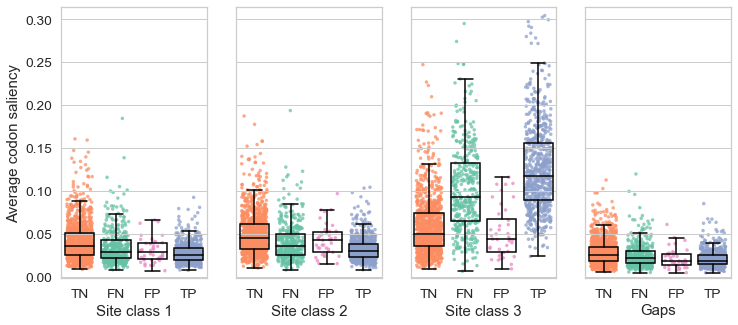

In [399]:
fig, axes = plt.subplots(1,4, figsize=(12,5),
                        sharey=True)

sns.set(font_scale=1.25)

tp_fn_pal = [sns.color_palette("Set2")[1],
             sns.color_palette("Set2")[0],
             sns.color_palette("Set2")[3],
             sns.color_palette("Set2")[2]]



for i in range(4):
    a = sns.boxplot(data=df, y="{}".format(i),
                x="prediction",
                ax=axes[i],
                showfliers = False,
                palette=tp_fn_pal)
    a = sns.stripplot(data=df, y="{}".format(i),
                x="prediction",
                ax=axes[i],
                alpha=.75,
                zorder=0,
                jitter=.35,
                palette=tp_fn_pal,
                size=3.5
    )
    
    for art_i, artist in enumerate(axes[i].artists):
        col1 = artist.get_facecolor()
        col = "black"

        r, g, b, a = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor((r, g, b, 0))
        for j in range(art_i*5,art_i*5+5):
            line = axes[i].lines[j]
            line.set_color(col)
            #line.set_mfc(col1)
            #line.set_mec(col1)
    axes[i].set_xlabel("Site class {}".format(i+1))
    axes[i].set_ylabel("")
    axes[i].set_ylim(top=0.315)
axes[0].set_ylabel("Average codon saliency")
sns.set_style("whitegrid")
axes[3].set_xlabel("Gaps")

plt.savefig("figures/baseline/codon_saliency_boxplots_ylim.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

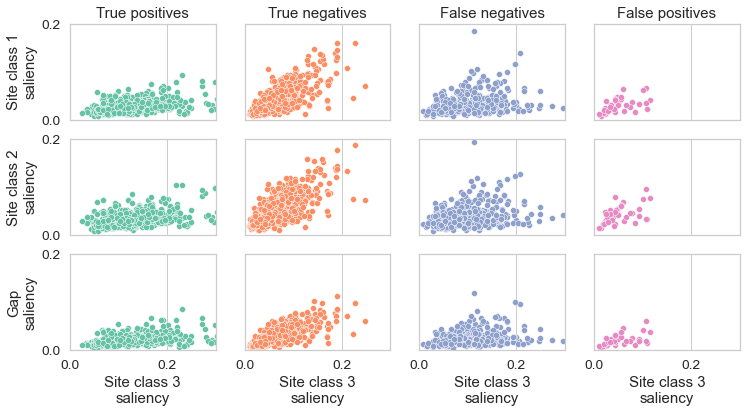

In [395]:
fig, axes = plt.subplots(3,4, figsize=(12,6),
                         sharey=True, sharex=True)

ylabs = ["Site class 1", "Site class 2", "Gap"]
pred_list = ["True positives", "True negatives", "False negatives", "False positives"]
pr_list = ["TP", "TN", "FN", "FP"]

for i in [0,1,3]:
    for pred in range(len(pred_list)):
        axis_i = i
        if i == 3:
            axis_i = 2
        sns.scatterplot(x="2", y="{}".format(i), data=df[df["prediction"] == pr_list[pred]],
                        ax=axes[axis_i][pred],
                        color=sns.color_palette("Set2")[pred])
        
        
for pred in range(len(pred_list)):
    for i in range(3):
        axes[i][pred].set_yticks(np.arange(0, 0.7, 0.2))
        axes[i][pred].set_xticks(np.arange(0, 0.7, 0.2))
        axes[-1][pred].set_xlabel("Site class 3\nsaliency")
        axes[i][pred].set_xlim(0,0.3)
        axes[i][pred].set_ylim(0,0.2)

    axes[0][pred].set_title(pred_list[pred])

for i in range(3):
    axes[i][0].set_ylabel(ylabs[i] + "\nsaliency")
    
# plt.savefig("figures/baseline/siteclass3_saliency_scatters.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [ ]:
        "#90CAF9",
        "#FFCC80",
        "#BF360C",
        "#ECEFF1",
        pad_col

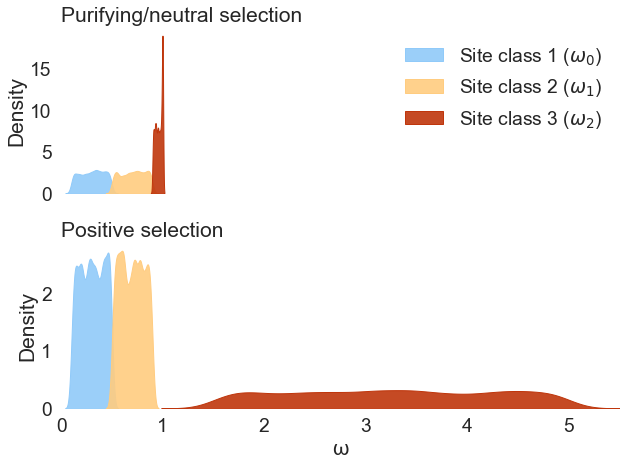

In [44]:
fig, axes = plt.subplots(2,1,figsize=(10,7),
                         sharex=True)

site_pal = ["#90CAF9", "#FFCC80", "#BF360C"]


for true_y in range(2):
    true_data = df[df["true_y"] == true_y]
    for omega in range(3):
        sns.kdeplot(data=true_data, x="omega_{}".format(omega),
                    ax=axes[true_y], label="Site class {0} ($ω_{1}$)".format(omega+1, omega),
                    shade=True,
                    color=site_pal[omega],
                    alpha=.9,
                    bw_adjust=0.7)
#plt.legend()
#axes[1].set_ylabel("")
axes[0].set_title("Purifying/neutral selection", loc="left")
axes[1].set_title("Positive selection", loc="left")
axes[0].set_xlabel("ω")
axes[1].set_xlabel("ω")

for ax_i in [0,1]:
    axes[ax_i].set_xlim(0,5.5)
#     axes[ax_i].axvline(1,
#                        linestyle="dashed",
#                        color="black",
#                        linewidth=1)

#axes[1].set_ylim(top=3)


axes[0].legend(frameon=False)

sns.set(palette=site_pal,
        style="whitegrid",
        font_scale=1.75)
sns.despine(left=True, bottom=True)
 
axes[0].grid(False)
axes[1].grid(False)
    
fig.subplots_adjust(hspace=.3)


plt.savefig("figures/baseline/site_omega_kdes.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

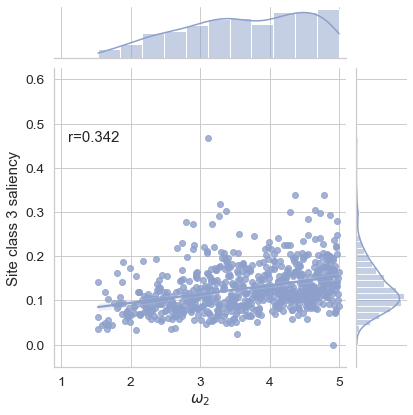

In [557]:
true_data = df[df["prediction"] == "TP"]
true_data = true_data.dropna()

corr = stats.pearsonr(true_data["omega_2"], true_data["2"])


jp = sns.jointplot(data=df[df["prediction"] == "TP"], x="omega_2", y="2",
                   kind="reg",
                   color=sns.color_palette("Set2")[2])
plt.xlim(left=0.895, right=5.1)
plt.ylim(bottom=-0.05, top=0.625)

plt.text(x=1.1, y=0.46, s="r=" + str(round(corr[0], 3)))
plt.ylabel("Site class 3 saliency")
plt.xlabel("$ω_{2}$")
sns.set_style("whitegrid")

plt.savefig("figures/baseline/siteclass3_omega_corr_TP.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

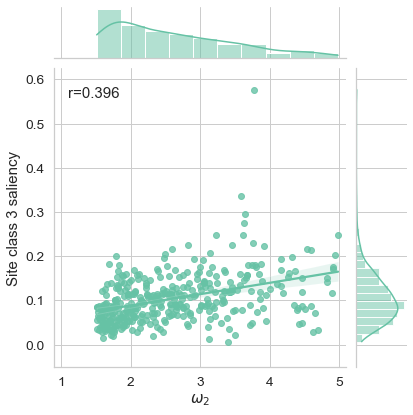

In [558]:
true_data = df[df["prediction"] == "FN"]
true_data = true_data.dropna()

corr = stats.pearsonr(true_data["omega_2"], true_data["2"])

jp = sns.jointplot(data=df[df["prediction"] == "FN"], x="omega_2", y="2",
                   kind="reg",
                   color=sns.color_palette("Set2")[0])
plt.xlim(left=0.895, right=5.1)
plt.ylim(bottom=-0.05, top=0.625)

plt.text(x=1.1, y=0.56, s="r=" + str(round(corr[0], 3)))
plt.ylabel("Site class 3 saliency")
plt.xlabel("$ω_2$")

plt.savefig("figures/baseline/siteclass3_omega_corr_FN.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

In [370]:
tp_fn_df = df[df["prediction"].isin(["TP", "FN"])]

In [366]:
list(pos_df)

['0',
 '0median',
 '1',
 '1median',
 '2',
 '2median',
 '3',
 '3median',
 'del_len',
 'deletions',
 'fasta_path',
 'ins_len',
 'insertions',
 'normalised_total_saliency',
 'omega_0',
 'omega_1',
 'omega_2',
 'padding',
 'pred_y',
 'prediction',
 'root_length',
 'saliency_map',
 'total_saliency',
 'true_clustal_classes',
 'true_true_classes',
 'true_y',
 'clustal_lengths']

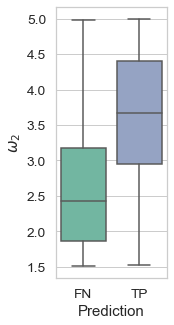

In [382]:
tp_fn_pal = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2]]

fig, ax = plt.subplots(figsize=(2,5))

sns.boxplot(data=tp_fn_df,
            x="prediction",
            y="omega_2",
            palette=tp_fn_pal)

ax.set_xlabel("Prediction")
ax.set_ylabel("$ω_2$")

plt.savefig("figures/baseline/tp_fn_omega2_boxes.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

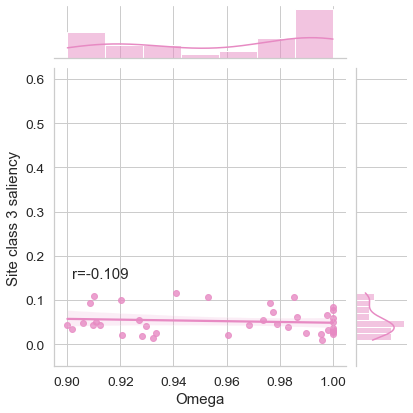

In [214]:
true_data = df[df["prediction"] == "FP"]
true_data = true_data.dropna()

corr = stats.pearsonr(true_data["omega_2"], true_data["2"])

jp = sns.jointplot(data=df[df["prediction"] == "FP"], x="omega_2", y="2",
                   kind="reg",
                   color=sns.color_palette("Set2")[3])
plt.xlim(left=0.895, right=1.005)
plt.ylim(bottom=-0.05, top=0.625)

plt.text(x=0.902, y=0.15, s="r=" + str(round(corr[0], 3)))
plt.ylabel("Site class 3 saliency")
plt.xlabel("Omega")
sns.set_style("whitegrid")

# plt.savefig("figures/baseline/siteclass3_omega_corr_FP.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

Text(0.5, 28.49999999999995, 'Omega')

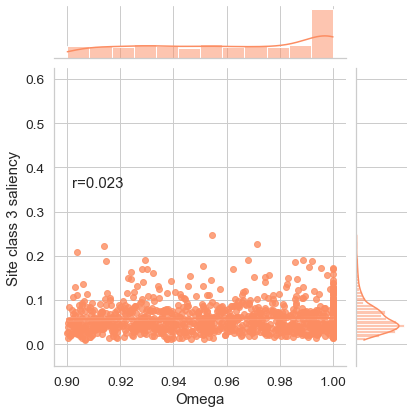

In [215]:
true_data = df[df["prediction"] == "TN"]
true_data = true_data.dropna()

corr = stats.pearsonr(true_data["omega_2"], true_data["2"])

jp = sns.jointplot(data=df[df["prediction"] == "TN"], x="omega_2", y="2",
                   kind="reg",
                   color=sns.color_palette("Set2")[1])
plt.xlim(left=0.895, right=1.005)
plt.ylim(bottom=-0.05, top=0.625)

plt.text(x=0.902, y=0.355, s="r=" + str(round(corr[0], 3)))
plt.ylabel("Site class 3 saliency")
plt.xlabel("Omega")

# plt.savefig("figures/baseline/siteclass3_omega_corr_TN.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [476]:
zero_df = df[df["2"] == 0]

In [51]:
a = np.array([[1,2,3],
              [3,2,4]])
translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
class_map = np.vectorize(my_dict.get)(class_map)

NameError: name 'my_dict' is not defined

IndexError: index 2 is out of bounds for axis 0 with size 2

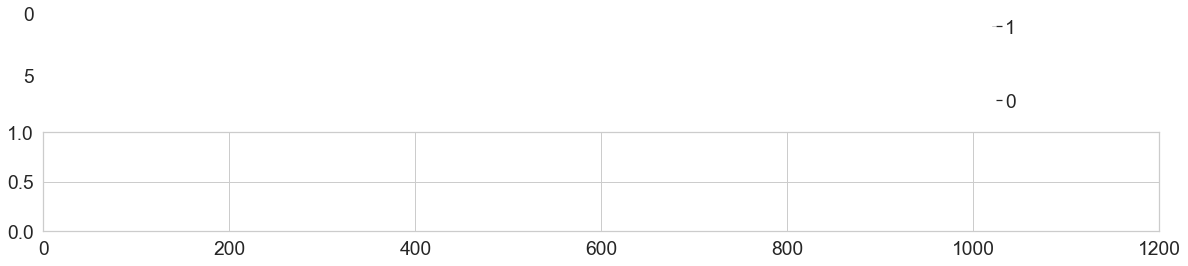

In [52]:
def inspect_maps(tp_df, ind):
    fig, ax = plt.subplots(2,1, figsize=(20,4),
                           sharex=True)
    class_map = tp_df.iloc[ind]["true_clustal_classes"]

    saliency_map = tp_df.iloc[ind]["saliency_map"]
    len_diff = len(saliency_map[0]) - len(class_map[0])
    if len_diff != 0:
        new_arr = []
        for i in class_map:
            to_app = np.append(i, np.repeat(4, len_diff))
            new_arr.append(to_app)
        class_map = np.asarray(new_arr)
        
    translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
    class_map = np.vectorize(translate_dic.get)(class_map)
    
    pad_col = "#B0BEC5"
    cmap = sns.color_palette("Set1", 3)
    cmap = [
 
    ][::-1]
    hm = sns.heatmap(class_map, cmap=cmap, ax=ax[0],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", "Zero padding"][::-1])
    
    hm2 = sns.heatmap(saliency_map, cmap="Greys_r",  ax=ax[1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    ax[0].set_ylabel("Alignment row")
    ax[1].set_ylabel("Alignment row")
    plt.xlabel("Alignment column")
#     if len_diff != 0:
#         for i in range(2):
#             ax[i].axvline(len(saliency_map[0]) - len_diff,
#                           color=pad_col,
#                           linestyle="dashed")
    
    for ax_i in range(2):
        ax[ax_i].set_yticklabels([1,2,3,4,5,6,7,8], rotation=0)
        cbar = ax[ax_i].collections[0].colorbar
        cbar.ax.tick_params(length=0)

#     for _, spine in hm.spines.items():
#         spine.set_visible(True)
#     for _, spine in hm2.spines.items():
#         spine.set_visible(True)
    
    sns.set(font_scale=1.25,
            style="white")

    plt.text(x=1275, y=0, s="Saliency")
    return fig, ax

inspect_maps(tp_df, 2)

In [304]:
bayes_df.head()

,m2_omega_ests,m2_omega_ses,m2_positions,m2_probs,m2_sigs,m7_omega_ests,m7_omega_ses,m7_positions,m7_probs,m7_sigs
0,"[2.506, 2.122, 2.847, 2.134, 1.934, 2.024, 2.8...","[0.899, 0.996, 0.654, 0.965, 0.945, 0.964, 0.6...","[6, 18, 23, 24, 25, 35, 45, 50, 56, 66, 82, 85...","[0.804, 0.619, 0.967, 0.633, 0.54, 0.58, 0.963...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2.38, 2.081, 2.588, 2.146, 2.005, 1.836, 2.06...","[0.671, 0.834, 0.432, 0.792, 0.827, 0.859, 0.8...","[6, 18, 23, 24, 25, 29, 35, 45, 50, 56, 62, 66...","[0.864, 0.7, 0.979, 0.74, 0.664, 0.57, 0.694, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
1,"[1.693, 1.97, 1.588, 1.656, 1.667, 1.552, 1.85...","[0.687, 0.658, 0.673, 0.682, 0.681, 0.687, 0.6...","[2, 6, 8, 15, 24, 29, 46, 56, 58, 59, 60, 75, ...","[0.614, 0.8, 0.544, 0.59, 0.598, 0.52, 0.727, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1.541, 1.371, 1.152, 1.645, 1.375, 1.494, 1.5...","[0.453, 0.422, 0.457, 0.444, 0.448, 0.453, 0.4...","[2, 3, 5, 6, 7, 8, 15, 17, 18, 19, 24, 25, 26,...","[0.847, 0.711, 0.513, 0.929, 0.71, 0.809, 0.83...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[2.077, 1.717, 2.241, 1.617, 1.862, 1.61, 2.04...","[0.641, 0.755, 0.519, 0.781, 0.725, 0.738, 0.6...","[4, 5, 14, 16, 24, 25, 32, 34, 45, 46, 47, 59,...","[0.811, 0.583, 0.918, 0.528, 0.673, 0.512, 0.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[2.08, 1.723, 2.218, 1.62, 1.553, 1.874, 1.616...","[0.626, 0.763, 0.509, 0.784, 0.753, 0.726, 0.7...","[4, 5, 14, 16, 22, 24, 25, 32, 34, 45, 46, 47,...","[0.859, 0.636, 0.947, 0.575, 0.531, 0.729, 0.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,"[6.21, 6.51, 3.842, 5.997, 5.568, 6.371, 4.298...","[2.109, 1.818, 2.906, 2.321, 2.623, 1.989, 3.1...","[37, 44, 106, 126, 164, 173, 190, 197, 211]","[0.942, 0.989, 0.536, 0.902, 0.826, 0.965, 0.5...","[0, 1, 0, 0, 0, 1, 0, 0, 1]","[5.717, 5.886, 3.874, 5.568, 5.236, 5.801, 3.9...","[1.883, 1.718, 2.669, 2.043, 2.307, 1.823, 2.8...","[37, 44, 106, 126, 164, 173, 190, 197, 211, 212]","[0.963, 0.993, 0.615, 0.932, 0.866, 0.976, 0.5...","[1, 1, 0, 0, 0, 1, 0, 0, 1, 0]"
4,"[2.851, 2.043, 2.015, 2.305, 2.648, 2.972, 3.1...","[1.074, 1.178, 1.103, 1.268, 1.089, 0.978, 0.8...","[2, 3, 9, 15, 23, 43, 48, 50, 52, 55, 58, 64, ...","[0.846, 0.532, 0.531, 0.625, 0.78, 0.901, 0.98...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.772, 2.038, 2.044, 2.254, 1.909, 2.638, 1.9...","[0.973, 1.136, 1.082, 1.189, 1.13, 0.998, 1.11...","[2, 3, 9, 15, 21, 23, 27, 43, 48, 50, 52, 55, ...","[0.871, 0.57, 0.584, 0.649, 0.512, 0.826, 0.53...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [47]:
def generate_beb_df(bayes_df, model_n, ind, saliency_len):
    ests = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_omega_ests".format(model_n)]))
    ses = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_omega_ses".format(model_n)]))
    probs = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_probs".format(model_n)]))
    sigs = dict(zip(bayes_df.iloc[ind]["{}_positions".format(model_n)], bayes_df.iloc[ind]["{}_sigs".format(model_n)]))

    x_vals = list(range(saliency_len))
    beb_for_df = {
        "positions": x_vals,
        "omegas": [],
        "ses": [],
        "probs": [],
        "sig": []
    }

    codon_keys = [k*3 for k in list(ests.keys())]

    for i in range(saliency_len):
        if i in codon_keys:
            i = int(i/3)
            beb_for_df["omegas"].append(ests[i])
            beb_for_df["ses"].append(ses[i])
            beb_for_df["probs"].append(probs[i])
            beb_for_df["sig"].append(sigs[i])
        else:
            beb_for_df["omegas"].append(0)
            beb_for_df["ses"].append(0)
            beb_for_df["probs"].append(0)
            beb_for_df["sig"].append(np.nan)
    beb_df = pd.DataFrame.from_dict(beb_for_df)
    return beb_df

In [58]:
bayes_df["prediction"] = df["prediction"]
tp_bayes_df = bayes_df[bayes_df["prediction"] == "TP"]

In [57]:
max_point = np.nanmax(np.concatenate([sig50,sig95,sig99]))
max_err = np.nanmax(np.concatenate([sig50_err,sig95_err,sig99_err]))
plt_ylim = max_point + max_err
if (float(plt_ylim) % 1) >= 0.5:
    plt_ylim = np.ceil(plt_ylim)
else:
    plt_ylim = round(plt_ylim) + 0.5

NameError: name 'sig50' is not defined

In [59]:
tmp_beb_df = generate_beb_df(tp_bayes_df, "m7", 5)

tmp_beb_df["omegas"] = tmp_beb_df["omegas"].replace({0:np.nan})

sig50, sig95, sig99 = [], [], []
sig50_err, sig95_err, sig99_err = [], [], []


for i,j in enumerate(list(tmp_beb_df["omegas"])):
    if tmp_beb_df["sig"][i] == 0:
        sig50.append(j)
        sig50_err.append(tmp_beb_df["ses"][i])
        sig95.append(np.NaN)
        sig95_err.append(np.NaN)
        sig99.append(np.NaN)
        sig99_err.append(np.NaN)
    elif tmp_beb_df["sig"][i] == 1:
        sig50.append(np.NaN)
        sig50_err.append(np.NaN)
        sig95.append(j)
        sig95_err.append(tmp_beb_df["ses"][i])
        sig99.append(np.NaN)
        sig99_err.append(np.NaN)
    else:
        sig50.append(np.NaN)
        sig50_err.append(np.NaN)
        sig95.append(np.NaN)
        sig95_err.append(np.NaN)
        sig99.append(j)
        sig99_err.append(tmp_beb_df["ses"][i])

max_point = np.nanmax(np.concatenate([sig50,sig95,sig99]))
max_err = np.nanmax(np.concatenate([sig50_err,sig95_err,sig99_err]))
plt_upper_ylim = max_point + max_err
if (float(plt_upper_ylim) % 1) >= 0.5:
    plt_upper_ylim = np.ceil(plt_upper_ylim)
else:
    plt_upper_ylim = round(plt_upper_ylim) + 0.5
min_point = np.nanmin(np.concatenate([sig50,sig95,sig99]))
plt_lower_ylim = min_point - max_err
if (float(plt_lower_ylim) % 1) <= 0.5:
    plt_lower_ylim = np.floor(plt_ylim)
else:
    plt_lower_ylim = round(plt_lower_ylim) - 0.5
    
r1 = np.asarray(tmp_beb_df["positions"])

ms = 6
ls = 2
fs = 12
barwidth = .2

fig, ax = plt.subplots(figsize=(20,2))

ax.errorbar(r1, sig50,
            color="lightgrey",
            label='≥0.5',
            fmt='-o',
            yerr=sig50_err,
            ls="none",
            markersize=ms,
            elinewidth=ls,
            mfc="white")

ax.errorbar(r1, sig95,
            color='#757575',
            label='≥0.95',
            fmt='-o',
            yerr=sig95_err,
            ls="none",
            markersize=ms,
            elinewidth=ls,
            mfc="white",
            zorder=25)

ax.errorbar(r1, sig99,
            color='black',
            label='≥0.99',
            fmt='-o',
            yerr=sig99_err,
            ls="none",
            markersize=ms,
            elinewidth=ls,
            zorder=50)

for i,j in enumerate(sig99):
    if not np.isnan(j):
        ax.axvline(x=r1[i],
                   color="#BF360C",
                   linestyle="--",
                   linewidth=3)

ax.set_ylabel(r"BEB $\hat{ω}_2$")
ax.set_xlim(0, r1[-1])
ax.set_ylim(plt_lower_ylim,plt_upper_ylim)
ax.legend()

TypeError: generate_beb_df() missing 1 required positional argument: 'saliency_len'

True

In [93]:
tp_df.iloc[34]

0                                                                            0
0median                                                                      0
1                                                                            0
1median                                                                      0
2                                                                            0
2median                                                                      0
3                                                                            0
3median                                                                      0
del_len                                                                1.56452
deletions                                                                   62
fasta_path                   /hps/nobackup/research/goldmans/conor/omega_ai...
ins_len                                                                1.72308
insertions                                          

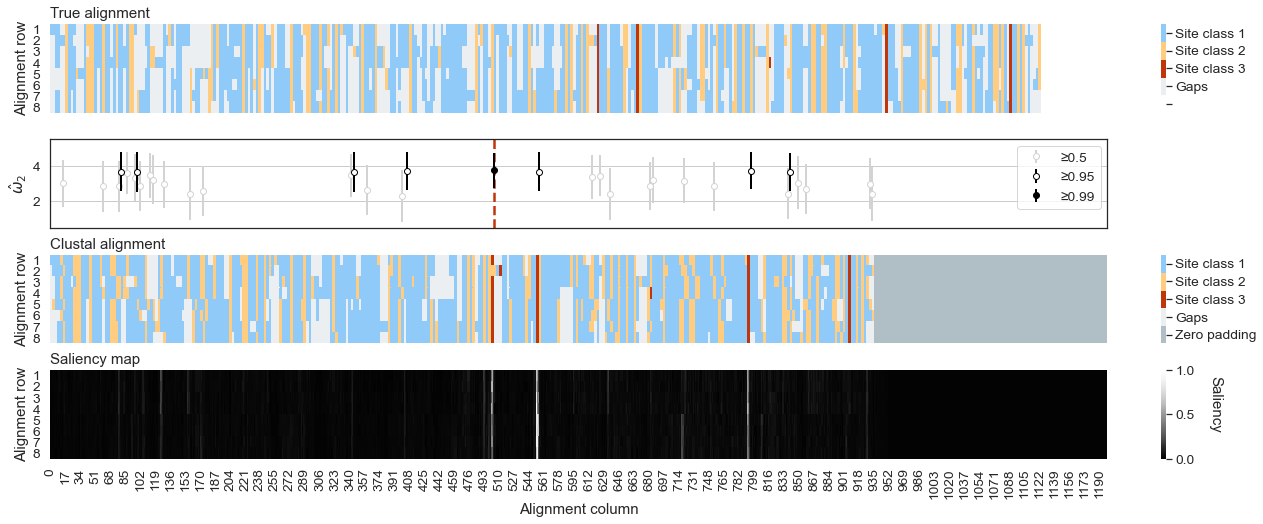

In [312]:
def pad_map(class_map, saliency_map, clustal=True):
    len_diff = len(saliency_map[0]) - len(class_map[0])
    pad_val = 4
    if len_diff != 0:
        new_arr = []
        for i in class_map:
            to_app = np.append(i, np.repeat(pad_val, len_diff))
            new_arr.append(to_app)
        class_map = np.asarray(new_arr)
    return class_map


def inspect_true_maps(tp_df, bayes_df, ind):
    # define site and saliency maps
    saliency_map = tp_df.iloc[ind]["saliency_map"]
    true_map = pad_map(tp_df.iloc[ind]["true_true_classes"], saliency_map)
    class_map = pad_map(tp_df.iloc[ind]["true_clustal_classes"], saliency_map)    
    translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
    class_map = np.vectorize(translate_dic.get)(class_map)
    true_map = np.vectorize(translate_dic.get)(true_map)
    
    # def bayes empirical bayes map
    # bayes_map = bayes_df.iloc[ind]["m7_omega_ests"]

    tmp_beb_df = generate_beb_df(bayes_df, "m7", ind, len(saliency_map[0]))

    tmp_beb_df["omegas"] = tmp_beb_df["omegas"].replace({0:np.nan})

    sig50, sig95, sig99 = [], [], []
    sig50_err, sig95_err, sig99_err = [], [], []


    for i,j in enumerate(list(tmp_beb_df["omegas"])):
        if tmp_beb_df["sig"][i] == 0:
            sig50.append(j)
            sig50_err.append(tmp_beb_df["ses"][i])
            sig95.append(np.nan)
            sig95_err.append(np.nan)
            sig99.append(np.nan)
            sig99_err.append(np.nan)
        elif tmp_beb_df["sig"][i] == 1:
            sig50.append(np.nan)
            sig50_err.append(np.nan)
            sig95.append(j)
            sig95_err.append(tmp_beb_df["ses"][i])
            sig99.append(np.nan)
            sig99_err.append(np.nan)
        else:
            sig50.append(np.nan)
            sig50_err.append(np.nan)
            sig95.append(np.nan)
            sig95_err.append(np.nan)
            sig99.append(j)
            sig99_err.append(tmp_beb_df["ses"][i])

    max_point = np.nanmax(np.concatenate([sig50,sig95,sig99]))
    max_err = np.nanmax(np.concatenate([sig50_err,sig95_err,sig99_err]))
    plt_upper_ylim = max_point + max_err
    if (float(plt_upper_ylim) % 1) >= 0.5:
        plt_upper_ylim = np.ceil(plt_upper_ylim)
    else:
        plt_upper_ylim = round(plt_upper_ylim) + 0.5
    min_point = np.nanmin(np.concatenate([sig50,sig95,sig99]))
    plt_lower_ylim = min_point - max_err
    if (float(plt_lower_ylim) % 1) <= 0.5:
        plt_lower_ylim = np.floor(plt_ylim)
    else:
        plt_lower_ylim = round(plt_lower_ylim) - 0.5

    r1 = np.asarray(tmp_beb_df["positions"])

    fig, ax = plt.subplots(4,2, figsize=(20,8),
                           sharex="col",
                           gridspec_kw={'width_ratios':[100,.5]})
    ms = 6
    ls = 2
    fs = 12
    barwidth = .2

    pad_col = "#B0BEC5"
    cmap = [
        "#90CAF9",
        "#FFCC80",
        "#BF360C",
        "#ECEFF1",
        pad_col
    ][::-1]
    
    cmap_true = [
        "white",
        "#ECEFF1",
        "#BF360C",
        "#FFCC80",
        "#90CAF9"
    ]
    
    hm = sns.heatmap(true_map, cmap=cmap_true,
                     ax=ax[0][0], cbar_ax=ax[0][1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", ""][::-1])
    

    ax[1,0].errorbar(r1, sig50,
                color="lightgrey",
                label='≥0.5',
                fmt='-o',
                yerr=sig50_err,
                ls="none",
                markersize=ms,
                elinewidth=ls,
                mfc="white")

    ax[1,0].errorbar(r1, sig95,
                #color='#757575',
                color="black",
                label='≥0.95',
                fmt='-o',
                yerr=sig95_err,
                ls="none",
                markersize=ms,
                elinewidth=ls,
                mfc="white",
                zorder=25)

    if len(pd.Series(sig99).unique()) > 1:
        ax[1,0].errorbar(r1, sig99,
                    color='black',
                    label='≥0.99',
                    fmt='-o',
                    yerr=sig99_err,
                    ls="none",
                    markersize=ms,
                    elinewidth=ls,
                    zorder=50)

    for i,j in enumerate(sig99):
        if not np.isnan(j):
            ax[1][0].axvline(x=i,
                       color="#BF360C",
                       linestyle="--",
                       linewidth=2.5)

    ax[1,0].set_ylabel(r"$\hat{ω}_2$")
#     ax[1,0].set_xlim(0, r1[-1])
    ax[1,0].set_ylim(plt_lower_ylim,plt_upper_ylim)
    ax[1,0].legend()
#     ax[1,0].yaxis.grid()
    
    hm = sns.heatmap(class_map, cmap=cmap,
                     ax=ax[2,0], cbar_ax=ax[2,1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", "Zero padding"][::-1])
    
    hm2 = sns.heatmap(saliency_map, cmap="Greys_r",
                     ax=ax[3,0], cbar_ax=ax[3,1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    for i in [0,2,3]:
        ax[i,0].set_ylabel("Alignment row")
    
    ax[1,0].yaxis.grid()
    ax[1,1].remove()
    
    ax[0,0].set_title("True alignment",
                    loc="left")
    ax[2,0].set_title("Clustal alignment",
                    loc="left")
    ax[3,0].set_title("Saliency map",
                    loc="left")
    
    ax[3,0].set_xlabel("Alignment column")
    
    ax[3,1].text(9, 0.325, "Saliency", rotation=270)
    
#     ax[0,0].set_xlim(0,600)
#     ax[1,0].set_xlim(0,600)
#     ax[2,0].set_xlim(0,600)
#     ax[3,0].set_xlim(0,600)
    
    
    sns.set(font_scale=1.25,
            style="white")
#     sns.despine(left=True,bottom=True)
#     plt.text(x=1275, y=0, s="Saliency")
    
    plt.subplots_adjust(hspace=0.3, wspace=0.1)

    for ax_i in [0,2,3]:
        ax[ax_i,0].set_yticklabels([1,2,3,4,5,6,7,8], rotation=0)
   #  return fig, ax
    return true_map

# tp_df = df[df["prediction"] == "TP"]
# truem = inspect_true_maps(tp_df, 1)
#inspect_true_maps(tp_df, tp_bayes_df, 41)
#inspect_true_maps(tp_df, tp_bayes_df, 24)
# inspect_true_maps(tp_df, tp_bayes_df, 34)
maps = inspect_true_maps(tp_df, tp_bayes_df, 41)

plt.savefig("figures/baseline/alignment_map_beb_comparison2.pdf",
            format="pdf",
            facecolor="white",
            bbox_inches="tight")

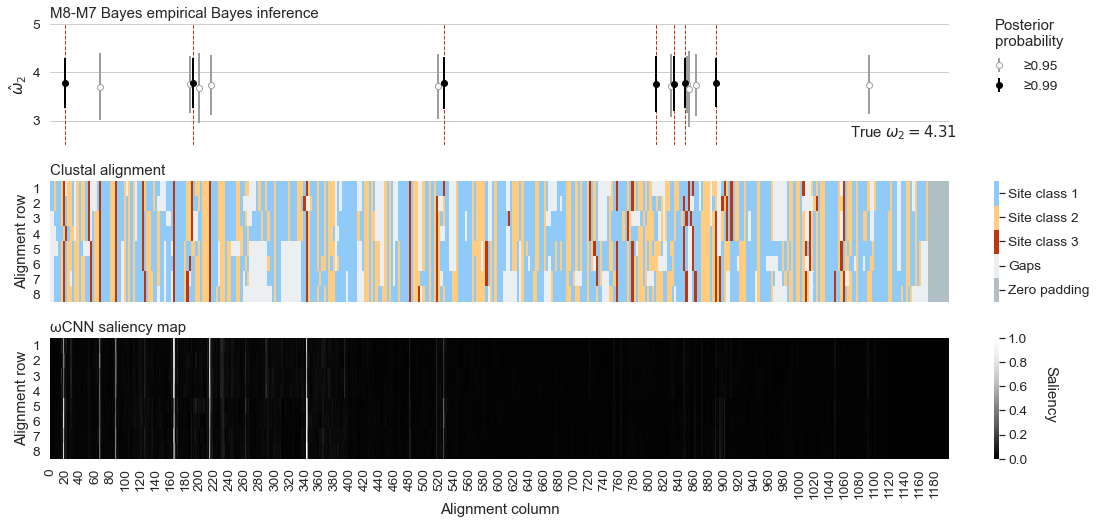

In [263]:
from matplotlib.colors import TwoSlopeNorm


def pad_map(class_map, saliency_map, true_alignment=False):
    len_diff = len(saliency_map[0]) - len(class_map[0])
    pad_val = 4
    if true_alignment:
        pad_val = 5
    if len_diff != 0:
        new_arr = []
        for i in class_map:
            to_app = np.append(i, np.repeat(pad_val, len_diff))
            new_arr.append(to_app)
        class_map = np.asarray(new_arr)
    return class_map


def inspect_true_maps(tp_df, bayes_df, ind):
    # define site and saliency maps
    saliency_map = tp_df.iloc[ind]["saliency_map"]
    class_map = tp_df.iloc[ind]["true_clustal_classes"]
    len_saliency = len(saliency_map[0])
    pad_col = "#B0BEC5"

    # true_map = tp_df.iloc[ind]["true_true_classes"]
#     print(len_saliency)
#     print(len(true_map[0]))
    if len(class_map[0]) == len_saliency:
        n_cols = 4
        translate_dic = {0:3, 1:2, 2:1, 3:0}
        cmap = [
            "#90CAF9",
            "#FFCC80",
            "#BF360C",
            "#ECEFF1"
        ][::-1]
    else:
        n_cols = 5
        class_map = pad_map(class_map, saliency_map)
        translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
        cmap = [
            "#90CAF9",
            "#FFCC80",
            "#BF360C",
            "#ECEFF1",
            pad_col
        ][::-1]

    true_omega = tp_df.iloc[ind]["omega_2"]
    class_map = np.vectorize(translate_dic.get)(class_map)
   
    # def bayes empirical bayes map
    # bayes_map = bayes_df.iloc[ind]["m7_omega_ests"]

    tmp_beb_df = generate_beb_df(bayes_df, "m7", ind, len(saliency_map[0]))

    tmp_beb_df["omegas"] = tmp_beb_df["omegas"].replace({0:np.nan})

    sig95, sig99 = [], []
    sig95_err, sig99_err = [], []


    for i,j in enumerate(list(tmp_beb_df["omegas"])):
        if tmp_beb_df["sig"][i] == 0:
            sig95.append(np.NaN)
            sig95_err.append(np.NaN)
            sig99.append(np.NaN)
            sig99_err.append(np.NaN)
        elif tmp_beb_df["sig"][i] == 1:
            sig95.append(j)
            sig95_err.append(tmp_beb_df["ses"][i])
            sig99.append(np.NaN)
            sig99_err.append(np.NaN)
        else:
            sig95.append(np.NaN)
            sig95_err.append(np.NaN)
            sig99.append(j)
            sig99_err.append(tmp_beb_df["ses"][i])

    max_point = np.nanmax(np.concatenate([sig95,sig99]))
    max_err = np.nanmax(np.concatenate([sig95_err,sig99_err]))
    plt_upper_ylim = max_point + max_err

    if (float(plt_upper_ylim) % 1) >= 0.5:
        plt_upper_ylim = np.ceil(plt_upper_ylim)
    else:
        plt_upper_ylim = round(plt_upper_ylim) + 0.5
    min_point = np.nanmin(np.concatenate([sig95,sig99]))
    plt_lower_ylim = min_point - max_err
    if (float(plt_lower_ylim) % 1) <= 0.5:
        plt_lower_ylim = np.floor(plt_lower_ylim)
    else:
        plt_lower_ylim = round(plt_lower_ylim) - 0.5

    r1 = np.asarray(tmp_beb_df["positions"]) - 1.5

    fig, ax = plt.subplots(3,2, figsize=(17,8),
                           sharex="col",
                           gridspec_kw={'width_ratios':[100,.5]})
    ms = 6
    ls = 2
    fs = 12
    barwidth = .2


    ax[0,0].errorbar(r1, sig95,
                color='#9E9E9E',
                label='≥0.95',
                fmt='-o',
                yerr=sig95_err,
                ls="none",
                markersize=ms,
                elinewidth=ls,
                mfc="white",
                zorder=25)

    ax[0,0].errorbar(r1, sig99,
                color='black',
                label='≥0.99',
                fmt='-o',
                yerr=sig99_err,
                ls="none",
                markersize=ms,
                elinewidth=ls,
                zorder=50)

    for i,j in enumerate(sig99):
        if not np.isnan(j):
            ax[0][0].axvline(x=i-1.5,
                       color="#BF360C",
                       linestyle="--",
                       linewidth=1)

    ax[0,0].set_ylabel(r"$\hat{ω}_2$")
#     ax[1,0].set_xlim(0, r1[-1])
    ax[0,0].set_ylim(plt_lower_ylim,plt_upper_ylim)
#     ax[0,0].set_ylim(0.9,5.1)
#     ax[0,0].set_yticks(np.arange(1, 6, 1))

    legend = ax[0,0].legend(bbox_to_anchor=(1.135, .8),
                            frameon=False)
    #legend.get_frame().set_facecolor('none')

    
    ax[0,0].yaxis.grid()
    
    ax[0,1].remove()
    
    hm = sns.heatmap(class_map, cmap=cmap,
                     ax=ax[1,0], cbar_ax=ax[1,1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.5})
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n_cols * (n_cols/10 + i) for i in range(n_cols)])

    if n_cols == 5:
        colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", "Zero padding"][::-1])
    else:
        colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps"][::-1])
    hm2 = sns.heatmap(saliency_map, cmap="Greys_r",
                     ax=ax[2,0], cbar_ax=ax[2,1],
                     yticklabels=1,
                     vmin=0, vmax=1,
                     norm=TwoSlopeNorm(0.5),
                     rasterized=True,
                     cbar_kws={"shrink": 0.5})

#     ax[2,1].set_title("Saliency", loc="left")
    ax[2,1].text(11, 0.325, "Saliency", rotation=270)
    
    for i in [1,2]:
        ax[i,0].set_ylabel("Alignment row")
    
    ax[0,0].set_title("M8-M7 Bayes empirical Bayes inference",
                      loc="left")

    ax[1,0].set_title("Clustal alignment",
                    loc="left")
    ax[2,0].set_title("ωCNN saliency map",
                    loc="left")
    
    ax[2,0].set_xlabel("Alignment column")
    
    
    for ax_i in [1,2]:
        ax[ax_i,0].set_yticklabels([1,2,3,4,5,6,7,8], rotation=0)
#         cbar = ax[ax_i,1].collections[0].colorbar
#         cbar.ax.tick_params(length=0)
    
    sns.set(font_scale=1.25,
            style="white")
    sns.despine(left=True,bottom=True)
#     plt.text(x=1275, y=0, s="Saliency")
    
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
#     for i,j in enumerate(class_map[0]):
#         if j == 2:
#             print(i, sig95[i+1], sig99[i+1])
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    # place a text box in upper left in axes coords
#     ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#             verticalalignment='top', bbox=props)
    
    ax[0,0].text(.95, .1, r"True $ω_2={:.2f}$".format(true_omega),
                 horizontalalignment="center",
                 verticalalignment="center",
                 transform = ax[0,0].transAxes)#,
                 #bbox=props)
    
    ax[0,0].text(1.051,.92, "Posterior\nprobability",
                 horizontalalignment="left",
                 verticalalignment="center",
                 transform = ax[0,0].transAxes)
    
#     ax[0,0].text(1.3,.92, "Posterior\nprobability",
#                  horizontalalignment="left",
#                  verticalalignment="center",
#                  transform = ax[0,1].transAxes)

   #  return fig, ax
    return tmp_beb_df

# tp_df = df[df["prediction"] == "TP"]
# truem = inspect_true_maps(tp_df, 1)
# maybes: 334
cm = inspect_true_maps(tp_df, tp_bayes_df, 11)

# good examples: 104 saliency >>> bayes inference

# plt.savefig("figures/baseline/alignment_map_beb_comparison_example.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")

In [68]:
def pad_map(class_map, saliency_map, clustal=True):
    len_diff = len(saliency_map[0]) - len(class_map[0])
    pad_val = 4
    if len_diff != 0:
        new_arr = []
        for i in class_map:
            to_app = np.append(i, np.repeat(pad_val, len_diff))
            new_arr.append(to_app)
        class_map = np.asarray(new_arr)
    return class_map


def inspect_true_maps(tp_df, ind):
    # define site and saliency maps
    saliency_map = tp_df.iloc[ind]["saliency_map"]
    true_map = pad_map(tp_df.iloc[ind]["true_true_classes"], saliency_map)
    class_map = pad_map(tp_df.iloc[ind]["true_clustal_classes"], saliency_map)    
    translate_dic = {0:4, 1:3, 2:2, 3:1, 4:0}
    class_map = np.vectorize(translate_dic.get)(class_map)
    true_map = np.vectorize(translate_dic.get)(true_map)
    
    # def bayes empirical bayes map
    bayes_map = bayes_df.iloc[ind]["m7_omega_ests"]

    
    
    fig, ax = plt.subplots(4,1, figsize=(20,8),
                           sharex=True)
    pad_col = "#B0BEC5"
    cmap = [
        "#90CAF9",
        "#FFCC80",
        "#BF360C",
        "#ECEFF1",
        pad_col
    ][::-1]
    
    cmap_true = [
        "white",
        "#ECEFF1",
        "#BF360C",
        "#FFCC80",
        "#90CAF9"
    ]
    
    hm = sns.heatmap(true_map, cmap=cmap_true, ax=ax[0],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", ""][::-1])
    
    hm = sns.heatmap(class_map, cmap=cmap, ax=ax[1],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    colorbar = hm.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["Site class 1", "Site class 2", "Site class 3", "Gaps", "Zero padding"][::-1])
    
    hm2 = sns.heatmap(saliency_map, cmap="Greys_r",  ax=ax[2],
                     yticklabels=1,
                     rasterized=True,
                     cbar_kws={"shrink": 0.75})
    for i in range(3):
        ax[i].set_ylabel("Alignment row")
    
    ax[0].set_title("True alignment (for comparison)",
                    loc="left")
    ax[1].set_title("Clustal alignment",
                    loc="left")
    ax[2].set_title("Saliency map",
                    loc="left")
    
    plt.xlabel("Alignment column")
    
    
    for ax_i in range(3):
        ax[ax_i].set_yticklabels([1,2,3,4,5,6,7,8], rotation=0)
        cbar = ax[ax_i].collections[0].colorbar
        cbar.ax.tick_params(length=0)
    
    sns.set(font_scale=1.25,
            style="white")

    plt.text(x=1275, y=0, s="Saliency")
    
    plt.subplots_adjust(hspace=0.35)
    
   #  return fig, ax
    return true_map


# tp_df = df[df["prediction"] == "TP"]
# truem = inspect_true_maps(tp_df, 1)
inspect_true_maps(fp_df, 8)

# plt.savefig("figures/baseline/alignment_map_comparison.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")

ValueError: negative dimensions are not allowed

In [343]:
al_lens = []
for i in df["true_clustal_classes"]:
    al_lens.append(len(i[0]))
df["clustal_lengths"] = al_lens

/nfs/research1/goldman/conor/tools/conda_home/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


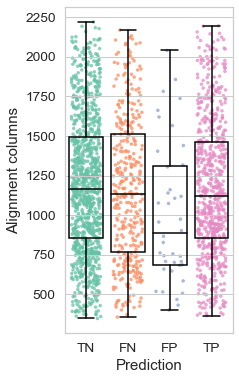

In [400]:
fig, ax = plt.subplots(figsize=(3,6))
sns.boxplot(data=df,
            y="clustal_lengths",
            x="prediction",
            showfliers = False,
            palette="Set2")

sns.stripplot(data=df,
              y="clustal_lengths",
              x="prediction",
              alpha=.75,
              zorder=0,
              jitter=.35,
              palette="Set2",
              size=3.5)

for art_i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    col = "black"

    r, g, b, a = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor((r, g, b, 0))
    for j in range(art_i*5,art_i*5+5):
        line = ax.lines[j]
        line.set_color(col)
        #line.set_mfc(col1)
        #line.set_mec(col1)

ax.set_ylabel("Alignment columns")
sns.set_style("whitegrid")
ax.set_xlabel("Prediction")

sns.set_style("whitegrid")
# ax.set_ylim(bottom=0.005, top=0.09)

# plt.savefig("figures/baseline/alignment_length_boxplots.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")

In [97]:
inspect_true_maps(tp_df, 12)

NameError: name 'inspect_true_maps' is not defined

In [545]:
tp_df = df[df["prediction"] == "TP"]

{0, 1, 2, 3, 4}


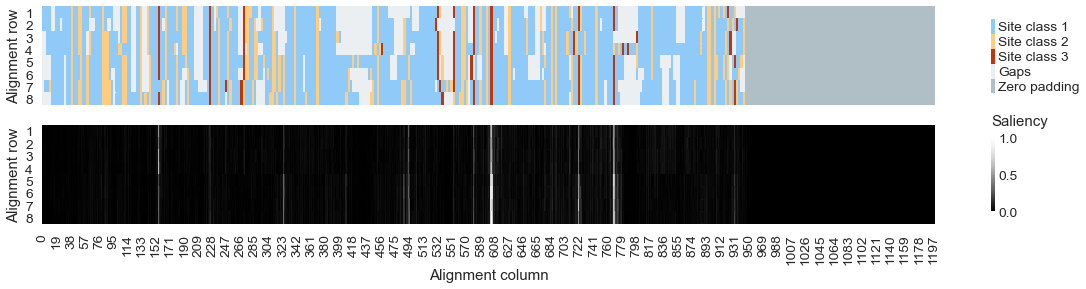

In [681]:
inspect_maps(tp_df, 1)
plt.savefig("figures/baseline/example_class_saliency_maps_TP.pdf",
            format="pdf",
            bbox_inches="tight",
            facecolor="white")

/nfs/research1/goldman/conor/tools/conda_home/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


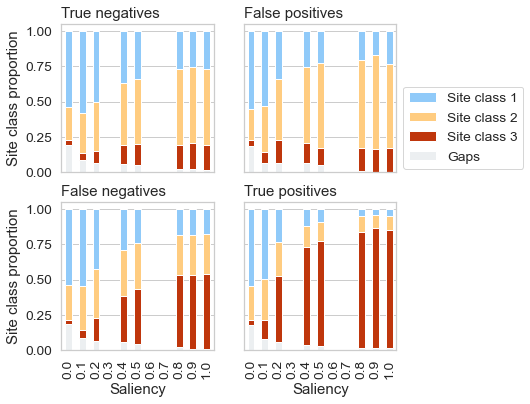

In [348]:
cmap = [
    "#90CAF9",
    "#FFCC80",
    "#BF360C",
    "#ECEFF1"][::-1]

pred_dic = {
    "TN": "True negatives",
    "FP": "False positives",
    "FN": "False negatives",
    "TP": "True positives"
}

fig, axes = plt.subplots(2, 2,
                         figsize=(6,6),
                         sharex=True,
                         sharey=True)

ax_c = 0
ax_c2 = -1

for pred in ["TN", "FP", "FN", "TP"]:
    ax_c2 += 1
    if ax_c2 == 2:
        ax_c2 = 0
        ax_c += 1
    sal_class_counts = []
    for i in range(0,11):
        sal_key = i/10
        sal_class_count = []
        for site_class in [3,2,1,0]:
            sal_class_count.append(saliency_bins[pred][sal_key].count(site_class))
        sal_class_count = [i / np.asarray(sal_class_count).sum() for i in sal_class_count]
        sal_class_count.insert(0, sal_key)
        sal_class_counts.append(sal_class_count)

    sal_df = pd.DataFrame(sal_class_counts,
                          columns=["saliency"] + ["Site class 1", "Site class 2", "Site class 3", "Gaps"][::-1])

    
    barc = sal_df.set_index("saliency").plot(kind='bar',
                                             stacked=True,
                                             ax=axes[ax_c][ax_c2],
                                             color=cmap,
                                             edgecolor="white",
                                             legend=False)
    sns.set_style("whitegrid")
    axes[ax_c][ax_c2].set_xlabel("Saliency")
    axes[ax_c][ax_c2].set_ylabel("Site class proportion")

    axes[ax_c][ax_c2].xaxis.grid(False) # Hide the horizontal gridlines

    axes[ax_c][ax_c2].set_title(pred_dic[pred], loc="left")

handles, labels = axes[ax_c][ax_c2].get_legend_handles_labels()
axes[ax_c][ax_c2].legend(reversed(handles), reversed(labels),
      loc='center left', bbox_to_anchor=(1, 1.5))
    
plt.savefig("figures/baseline/saliency_proportion_of_site_classes.pdf",
            bbox_inches="tight",
            format="pdf",
            facecolor="white")

In [93]:
from collections import defaultdict

In [140]:
saliency_dic = defaultdict(float)
n_of_sites = defaultdict(int)

for species in range(len(true_clustal_classes)):
    for i_codon, codon in enumerate(true_clustal_classes[species]):
        if np.isnan(codon):
            saliency_dic["gap"] += grad_eval[species][i_codon]
            n_of_sites["gap"] += 1
        else:
            saliency_dic[codon] += grad_eval[species][i_codon]
            n_of_sites[codon] += 1

for k, v in saliency_dic.items():
    saliency_dic[k] /= n_of_sites[k]

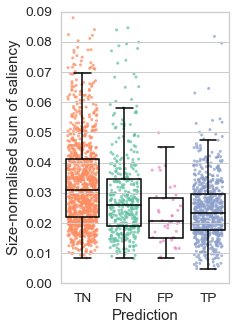

In [568]:
fig, ax = plt.subplots(figsize=(3,5))

tp_fn_pal = [sns.color_palette("Set2")[1],
             sns.color_palette("Set2")[0],
             sns.color_palette("Set2")[3],
             sns.color_palette("Set2")[2]]

sns.boxplot(data=df,
            y="normalised_total_saliency",
            x="prediction",
            showfliers = False,
            palette=tp_fn_pal)

sns.stripplot(data=df,
              y="normalised_total_saliency",
              x="prediction",
              alpha=.75,
              zorder=0,
              jitter=.35,
              palette=tp_fn_pal,
              size=3)

for art_i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    col = "black"

    r, g, b, a = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor((r, g, b, 0))
    for j in range(art_i*5,art_i*5+5):
        line = ax.lines[j]
        line.set_color(col)
        #line.set_mfc(col1)
        #line.set_mec(col1)

ax.set_ylabel("Size-normalised sum of saliency")
sns.set_style("whitegrid")
ax.set_xlabel("Prediction")

sns.set_style("whitegrid")
ax.set_ylim(bottom=0, top=0.09)

plt.savefig("figures/baseline/sum_of_saliency_per_prediction_class.pdf",
            format="pdf",
            facecolor="white",
            bbox_inches="tight")

In [444]:
site_count_df

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,omega_1,omega_2,prediction,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,0.643842,0.980570,TN,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,0.819956,0.989284,TN,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,0.579951,2.471407,FN,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,0.828496,0.907350,TN,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,0.857253,0.992764,TN,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.575824,0.221429,0.032967,0.169780,1365.0,1.58182,110.0,1.58772,114.0,0.194460,0.694255,0.957023,TN,0.035333,0.044438,0.082622,174.00020,181.00008,0.038071
2165,0.703252,0.104675,0.039295,0.152778,1107.0,1.63265,98.0,1.37647,85.0,0.387925,0.887826,0.906325,TN,0.034515,0.031191,0.098162,159.99970,116.99995,0.032228
2166,0.582609,0.242754,0.021014,0.153623,1035.0,1.49398,83.0,1.48101,79.0,0.473611,0.694621,4.177791,TP,0.032560,0.033825,0.106691,124.00034,116.99979,0.028794
2167,0.518814,0.260842,0.052296,0.168048,1176.0,1.50000,74.0,1.43210,81.0,0.134510,0.767375,0.986075,TN,0.049873,0.075600,0.077226,111.00000,116.00010,0.055533


In [446]:
a_dic

{'0': 0.5293824701195219,
 '1': 0.24925298804780877,
 '2': 0.058515936254980076,
 '3': 0.16284860557768924,
 'prediction': 'TP',
 'saliency_0': 0.028550657651088687,
 'omega_0': 0.43235838701226836,
 'total_saliency': 0.03190008388778255,
 'insertions': 122.0,
 'deletions': 119.0,
 'ins_len': 1.48361,
 'del_len': 1.48739,
 'total_insertions': 181.00042000000002,
 'total_deletions': 176.99941,
 'align_len': 1506,
 'saliency_1': 0.02964355933002053,
 'omega_1': 0.6672113465543421,
 'saliency_2': 0.10324541557289607,
 'omega_2': 2.3728403687681645}

In [450]:
site_count_df

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,omega_1,omega_2,prediction,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,0.643842,0.980570,TN,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,0.819956,0.989284,TN,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,0.579951,2.471407,FN,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,0.828496,0.907350,TN,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,0.857253,0.992764,TN,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.575824,0.221429,0.032967,0.169780,1365.0,1.58182,110.0,1.58772,114.0,0.194460,0.694255,0.957023,TN,0.035333,0.044438,0.082622,174.00020,181.00008,0.038071
2165,0.703252,0.104675,0.039295,0.152778,1107.0,1.63265,98.0,1.37647,85.0,0.387925,0.887826,0.906325,TN,0.034515,0.031191,0.098162,159.99970,116.99995,0.032228
2166,0.582609,0.242754,0.021014,0.153623,1035.0,1.49398,83.0,1.48101,79.0,0.473611,0.694621,4.177791,TP,0.032560,0.033825,0.106691,124.00034,116.99979,0.028794
2167,0.518814,0.260842,0.052296,0.168048,1176.0,1.50000,74.0,1.43210,81.0,0.134510,0.767375,0.986075,TN,0.049873,0.075600,0.077226,111.00000,116.00010,0.055533


In [449]:
site_count_df = pd.DataFrame()

for index, row in df.iterrows():
    a = row["true_clustal_classes"]
    size = a.size
    unique, counts = np.unique(a, return_counts=True)
    a_dic = dict(zip([str(i) for i in unique], counts))
    for k, v in a_dic.items():
        a_dic[k] = v / size
    a_dic["prediction"] = row["prediction"]
    for i in range(3):
        a_dic["saliency_{}".format(i)] = row["{}".format(i)]
        a_dic["omega_{}".format(i)] = row["omega_{}".format(i)]
        a_dic["total_saliency"] = row["normalised_total_saliency"]
        a_dic["insertions"] = row["insertions"]
        a_dic["deletions"] = row["deletions"]
        a_dic["ins_len"] = row["ins_len"]
        a_dic["del_len"] = row["del_len"]
        a_dic["total_insertions"] = row["insertions"] * row["ins_len"]
        a_dic["total_deletions"] = row["deletions"] * row["del_len"]
        a_dic["align_len"] = len(row["true_clustal_classes"][0])

    site_count_df = site_count_df.append(a_dic, ignore_index=True)
    
# col_labels = [
#  "Proportion of SC1",
#  "Proportion of SC2",
#  "Proportion of SC3",
#  "Proportion of Gaps",
#  "Omega 1",
#  "Omega 2",
#  "Omega 3",
#  "Prediction",
#  "Mean saliency of SC1",
#  "Mean saliency of SC2",
#  "Mean saliency of SC3",
#  "Normalised sum of saliency",
#  "Insertions",
#  "Deletions",
#  "Mean insertion length",
#  "Mean deletion length",
#  "Alignment length"
# ]
# site_count_df.columns = col_labels

In [316]:
site_count_df.head()

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,omega_1,omega_2,prediction,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,0.643842,0.980570,TN,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,0.819956,0.989284,TN,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,0.579951,2.471407,FN,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,0.828496,0.907350,TN,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,0.857253,0.992764,TN,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661


In [445]:
site_count_df

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,omega_1,omega_2,prediction,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,0.643842,0.980570,TN,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,0.819956,0.989284,TN,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,0.579951,2.471407,FN,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,0.828496,0.907350,TN,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,0.857253,0.992764,TN,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.575824,0.221429,0.032967,0.169780,1365.0,1.58182,110.0,1.58772,114.0,0.194460,0.694255,0.957023,TN,0.035333,0.044438,0.082622,174.00020,181.00008,0.038071
2165,0.703252,0.104675,0.039295,0.152778,1107.0,1.63265,98.0,1.37647,85.0,0.387925,0.887826,0.906325,TN,0.034515,0.031191,0.098162,159.99970,116.99995,0.032228
2166,0.582609,0.242754,0.021014,0.153623,1035.0,1.49398,83.0,1.48101,79.0,0.473611,0.694621,4.177791,TP,0.032560,0.033825,0.106691,124.00034,116.99979,0.028794
2167,0.518814,0.260842,0.052296,0.168048,1176.0,1.50000,74.0,1.43210,81.0,0.134510,0.767375,0.986075,TN,0.049873,0.075600,0.077226,111.00000,116.00010,0.055533


In [521]:
list(site_count_df)

['0',
 '1',
 '2',
 '3',
 'align_len',
 'del_len',
 'deletions',
 'ins_len',
 'insertions',
 'omega_0',
 'omega_1',
 'omega_2',
 'prediction',
 'saliency_0',
 'saliency_1',
 'saliency_2',
 'total_deletions',
 'total_insertions',
 'total_saliency']

ValueError: Could not interpret input 'Proportion of SC1'

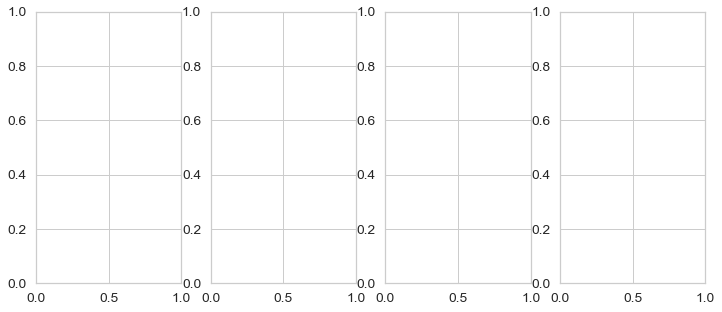

In [517]:
fig, axes = plt.subplots(1,4, figsize=(12,5))
for i in range(4):
    if i == 3:
        sc = "Gaps"
    else:
        sc = "SC" + str(i+1)
    sns.boxplot(data=site_count_df,
                x="prediction",
                y="Proportion of {}".format(sc),
                ax=axes[i],
                showfliers = False,
                palette="Set2")
    
    sns.stripplot(data=site_count_df,
                x="prediction",
                y="Proportion of {}".format(sc),
                ax=axes[i],
                alpha=.75,
                zorder=0,
                jitter=.35,
                palette="Set2",
                size=3.5
    )
    
    for art_i, artist in enumerate(axes[i].artists):
        col1 = artist.get_facecolor()
        col = "black"

        r, g, b, a = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor((r, g, b, 0))
        for j in range(art_i*5,art_i*5+5):
            line = axes[i].lines[j]
            line.set_color(col)
            #line.set_mfc(col1)
            #line.set_mec(col1)
    axes[i].set_xlabel("Site class {}".format(i+1))
    axes[i].set_ylabel("")
axes[0].set_ylabel("Proportion of codons")
sns.set_style("whitegrid")
axes[3].set_xlabel("Gaps")

plt.subplots_adjust(wspace=0.5)

# plt.savefig("figures/baseline/proportion_of_codons.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [317]:
fp_site_count_df = site_count_df[site_count_df["prediction"] == "FP"]

In [319]:
site_count_df

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,omega_1,omega_2,prediction,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,0.643842,0.980570,TN,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,0.819956,0.989284,TN,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,0.579951,2.471407,FN,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,0.828496,0.907350,TN,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,0.857253,0.992764,TN,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.575824,0.221429,0.032967,0.169780,1365.0,1.58182,110.0,1.58772,114.0,0.194460,0.694255,0.957023,TN,0.035333,0.044438,0.082622,174.00020,181.00008,0.038071
2165,0.703252,0.104675,0.039295,0.152778,1107.0,1.63265,98.0,1.37647,85.0,0.387925,0.887826,0.906325,TN,0.034515,0.031191,0.098162,159.99970,116.99995,0.032228
2166,0.582609,0.242754,0.021014,0.153623,1035.0,1.49398,83.0,1.48101,79.0,0.473611,0.694621,4.177791,TP,0.032560,0.033825,0.106691,124.00034,116.99979,0.028794
2167,0.518814,0.260842,0.052296,0.168048,1176.0,1.50000,74.0,1.43210,81.0,0.134510,0.767375,0.986075,TN,0.049873,0.075600,0.077226,111.00000,116.00010,0.055533


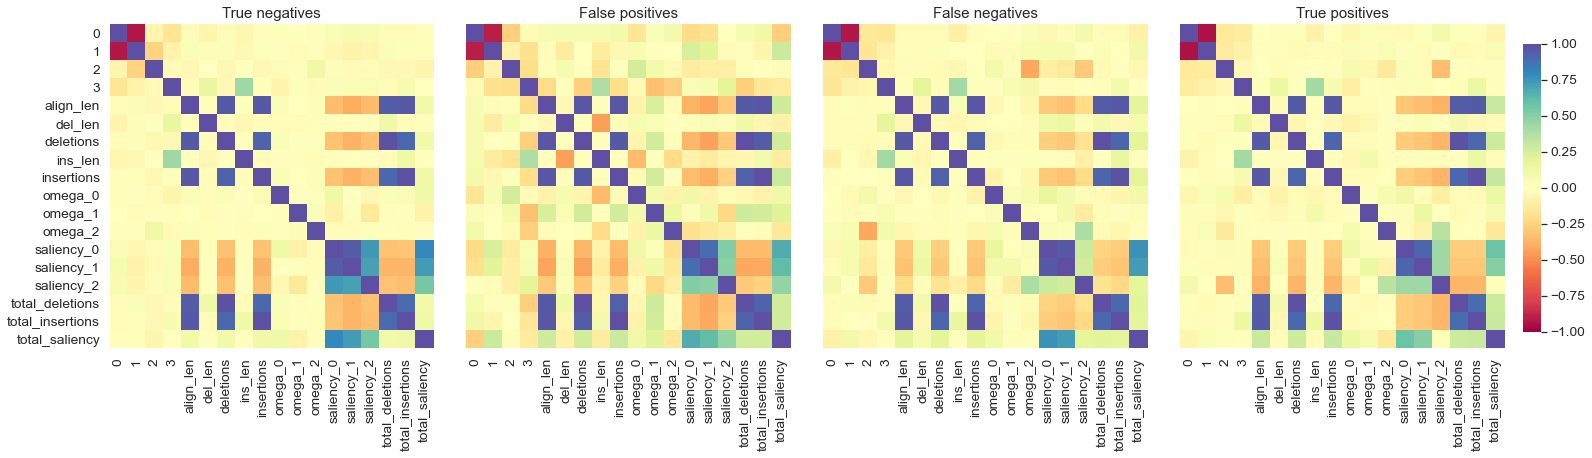

In [421]:
fig, ax = plt.subplots(1,4, figsize=(25,8),
                       sharex=True, sharey=True)
count = -1

cbar_ax = fig.add_axes([.91, .25, .01, .5])

for i, pred in enumerate(["TN", "FP", "FN", "TP"]):
    count += 1
    col_bar = False
    if count == 3:
        col_bar = True
    tmp_df = site_count_df[site_count_df["prediction"] == pred]
    sns.heatmap(tmp_df.corr(),
                ax=ax[count],
                vmin=-1, vmax=1,
                square=True,
                cbar=i==0,
                cbar_ax=None if i else cbar_ax,
                cmap="Spectral")
    ax[count].set_title(pred_dic[pred])
    
plt.subplots_adjust(wspace=0.1)
# cbar_ax.set_title("Correlation", loc="left")

# plt.savefig("figures/baseline/correlation_heatmaps.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             facecolor="white")

In [402]:
x_df

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,...,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency,PC1,PC2,PC3,PC4
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,...,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137,-0.524712,-0.615694,-0.672757,-1.233467
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,...,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867,-3.466758,1.879493,-0.807738,0.624749
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,...,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433,1.462531,-1.442725,1.425223,0.130737
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,...,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900,-0.570296,3.582605,0.672033,-0.328009
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,...,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661,-0.690142,-1.117981,1.956344,-0.968551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.575824,0.221429,0.032967,0.169780,1365.0,1.58182,110.0,1.58772,114.0,0.194460,...,0.035333,0.044438,0.082622,174.00020,181.00008,0.038071,-1.260478,0.832851,-0.515998,-0.058024
2165,0.703252,0.104675,0.039295,0.152778,1107.0,1.63265,98.0,1.37647,85.0,0.387925,...,0.034515,0.031191,0.098162,159.99970,116.99995,0.032228,0.088034,0.086047,-2.940678,-0.419403
2166,0.582609,0.242754,0.021014,0.153623,1035.0,1.49398,83.0,1.48101,79.0,0.473611,...,0.032560,0.033825,0.106691,124.00034,116.99979,0.028794,0.685458,-0.705278,-0.314388,1.041079
2167,0.518814,0.260842,0.052296,0.168048,1176.0,1.50000,74.0,1.43210,81.0,0.134510,...,0.049873,0.075600,0.077226,111.00000,116.00010,0.055533,1.147260,2.000193,0.164407,-0.628086


In [325]:
from sklearn.preprocessing import StandardScaler
x_df = site_count_df.dropna(axis="rows")
# x_df["info_content"] = x_df["Proportion of SC3"] * x_df["Omega 3"] 
x = x_df.loc[:, list(x_df.drop("prediction", axis=1).columns)].values
x = StandardScaler().fit_transform(x) # normalizing the features

assert round(np.mean(x), 2) == 0
assert np.std(x) == 1

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_x = pd.DataFrame(x, columns=feat_cols)

from sklearn.decomposition import PCA
pca = PCA(n_components=4)
x_pca = pca.fit_transform(x)

principal_df = pd.DataFrame(data = x_pca,
                                   columns = ["PC1", "PC2", "PC3", "PC4"])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# principal_breast_Df["prediction"] = x_df["prediction"]

x_df["PC1"] = list(principal_df["PC1"])
x_df["PC2"] = list(principal_df["PC2"])
x_df["PC3"] = list(principal_df["PC3"])
x_df["PC4"] = list(principal_df["PC4"])

Explained variation per principal component: [0.28669988 0.14875151 0.1080906  0.08629908]


/nfs/research1/goldman/conor/tools/conda_home/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/research1/goldman/conor/tools/conda_home/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/research1/goldman/conor/tools/conda_home/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [564]:
x_df.head()

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,...,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency,PC1,PC2,PC3,PC4
0,0.464706,0.309804,0.049020,0.176471,765.0,1.61111,54.0,1.58333,48.0,0.407319,...,0.036532,0.047217,0.098854,86.99994,75.99984,0.026047,2.139316,-0.914887,1.396601,0.666216
1,0.525412,0.297390,0.018544,0.158654,1092.0,1.62921,89.0,1.40789,76.0,0.288340,...,0.079232,0.086141,0.177064,144.99969,106.99964,0.070108,1.895280,2.771619,0.278023,-1.574218
2,0.638643,0.154867,0.052360,0.154130,1017.0,1.48148,81.0,1.50685,73.0,0.388724,...,0.027846,0.022327,0.104271,119.99988,110.00005,0.024600,0.586959,-1.655358,-1.657992,-0.684099
3,0.546875,0.267708,0.055729,0.129688,720.0,1.57143,56.0,1.44898,49.0,0.111390,...,0.023957,0.027204,0.129560,88.00008,71.00002,0.017703,1.991579,-2.653492,0.105109,-1.842091
4,0.408967,0.328125,0.099864,0.163043,552.0,1.48837,43.0,1.72500,40.0,0.290764,...,0.029438,0.036203,0.119195,63.99991,69.00000,0.017969,2.589437,-1.950562,1.880179,1.112422


In [1]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

var1, var2, var3, var4 = pca.explained_variance_ratio_

markers = ["v","X","^","P"]

for ii, i in enumerate(["TN", "FN", "TP", "FP"]):
    tmp_df = x_df[x_df["prediction"] == i]
    sns.scatterplot(data=tmp_df,
                    x="PC1",
                    y="PC2",
                    s=100,
                    marker=markers[ii],
                    palette="colorblind",
                    label=pred_dic[i],
                    ax=ax[0])
    
ax[0].set_xlabel("Principal component 1 ({:.2f}%)".format(var1*100))
ax[0].set_ylabel("Principal component 2 ({:.2f}%)".format(var2*100))

    
for ii, i in enumerate(["TN", "FN", "TP", "FP"]):
    tmp_df = x_df[x_df["prediction"] == i]
    sns.scatterplot(data=tmp_df,
                    x="PC3",
                    y="PC4",
                    s=100,
                    marker=markers[ii],
                    palette="colorblind",
                    label=pred_dic[i],
                    ax=ax[1])

ax[1].set_xlabel("Principal component 3 ({:.2f}%)".format(var3*100))
ax[1].set_ylabel("Principal component 4 ({:.2f}%)".format(var4*100))

NameError: name 'plt' is not defined

<AxesSubplot:xlabel='prediction', ylabel='align_len'>

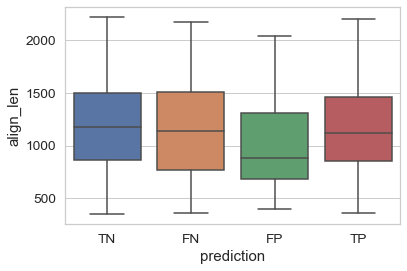

In [431]:
sns.boxplot(data=x_df,
               x="prediction",
               y="align_len")

In [430]:
list(x_df)

['0',
 '1',
 '2',
 '3',
 'align_len',
 'del_len',
 'deletions',
 'ins_len',
 'insertions',
 'omega_0',
 'omega_1',
 'omega_2',
 'prediction',
 'saliency_0',
 'saliency_1',
 'saliency_2',
 'total_deletions',
 'total_insertions',
 'total_saliency',
 'PC1',
 'PC2',
 'PC3',
 'PC4']

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

hue_var = "align_len"
hue_var1, hue_var2 = "align_len", "align_len"
var1, var2, var3, var4 = pca.explained_variance_ratio_

sns.scatterplot(data=x_df,
                x="PC1",
                y="PC2",
                style="prediction",
                hue=hue_var,
                s=80,
                ax=ax[0],
                palette="Set1")
sns.scatterplot(data=x_df,
                x="PC3",
                y="PC4",
                style="prediction",
                hue=hue_var,
                s=80,
                ax=ax[1],
                palette="Set1")

ax[0].set_xlabel("Principal component 1 ({0:.1f}%)".format(round(var1,3)*100))
ax[0].set_ylabel("Principal component 2 ({0:.1f}%)".format(round(var2,3)*100))

ax[1].set_xlabel("Principal component 3 ({0:.1f}%)".format(round(var3,3)*100))
ax[1].set_ylabel("Principal component 4 ({0:.1f}%)".format(round(var4,3)*100))

# norm = plt.Normalize(x_df[hue_var].min(), x_df[hue_var].max())
# sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm.set_array([])
# ax.set_ylim(-4.5,4.5)
# ax.set_xlim(-4.5,10.5)
# # Remove the legend and add a colorbar
# # ax.get_legend().remove()
# ax.figure.colorbar(sm,
#                    shrink=.75)

Text(0, 0.5, 'Principal component 4 (8.3%)')

Text(0, 0.5, 'Principal component 4 (8.6%)')

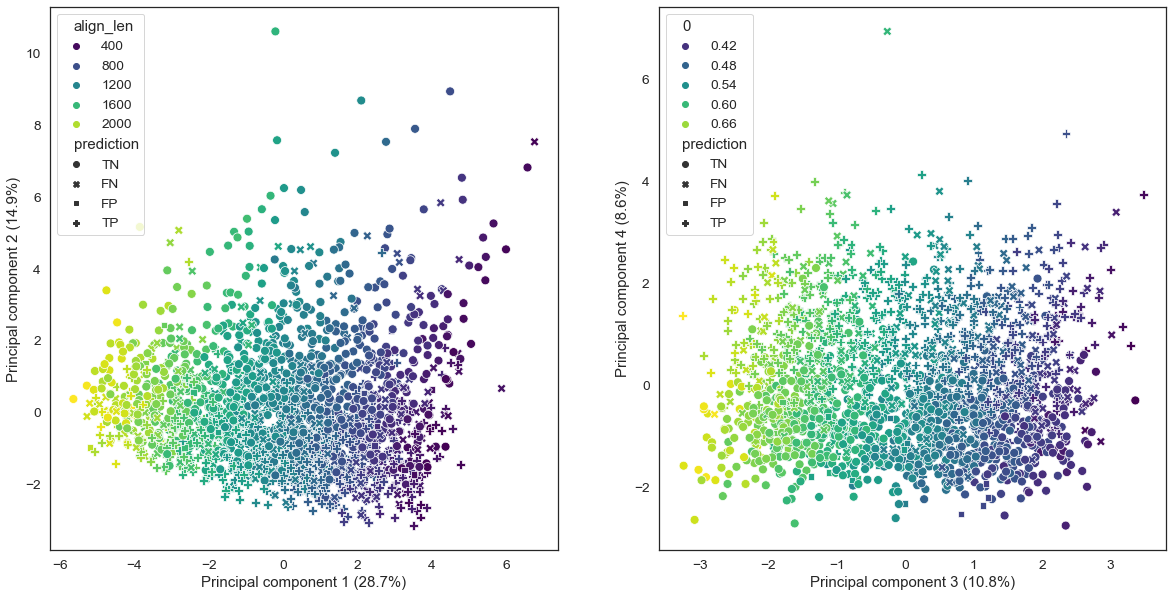

In [326]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

hue_var1, hue_var2 = "align_len", "0"
var1, var2, var3, var4 = pca.explained_variance_ratio_

sns.scatterplot(data=x_df,
                x="PC1",
                y="PC2",
                style="prediction",
                hue=hue_var1,
                s=80,
                ax=ax[0],
                palette="viridis")
sns.scatterplot(data=x_df,
                x="PC3",
                y="PC4",
                style="prediction",
                hue=hue_var2,
                s=80,
                ax=ax[1],
                palette="viridis")

ax[0].set_xlabel("Principal component 1 ({0:.1f}%)".format(round(var1,3)*100))
ax[0].set_ylabel("Principal component 2 ({0:.1f}%)".format(round(var2,3)*100))

ax[1].set_xlabel("Principal component 3 ({0:.1f}%)".format(round(var3,3)*100))
ax[1].set_ylabel("Principal component 4 ({0:.1f}%)".format(round(var4,3)*100))

# norm = plt.Normalize(x_df[hue_var].min(), x_df[hue_var].max())
# sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm.set_array([])
# ax.set_ylim(-4.5,4.5)
# ax.set_xlim(-4.5,10.5)
# # Remove the legend and add a colorbar
# # ax.get_legend().remove()
# ax.figure.colorbar(sm,
#                    shrink=.75)

In [404]:
pos_df = x_df[x_df["prediction"].isin(["TP", "FP"])]

In [339]:
x_df

,0,1,2,3,align_len,del_len,deletions,ins_len,insertions,omega_0,...,saliency_0,saliency_1,saliency_2,total_deletions,total_insertions,total_saliency,PC1,PC2,PC3,PC4
0,0.578997,0.225571,0.041878,0.153553,1182.0,1.68966,87.0,1.45000,100.0,0.258592,...,0.025482,0.026065,0.028072,147.00042,145.00000,0.024137,-0.524712,-0.615694,-0.672757,-1.233467
1,0.604563,0.223016,0.008333,0.164087,1890.0,1.48000,150.0,1.57325,157.0,0.267155,...,0.039020,0.053618,0.108333,222.00000,247.00025,0.040867,-3.466758,1.879493,-0.807738,0.624749
2,0.448694,0.304571,0.072295,0.174440,804.0,1.59016,61.0,1.57353,68.0,0.366492,...,0.027005,0.024421,0.125551,96.99976,107.00004,0.021433,1.462531,-1.442725,1.425223,0.130737
3,0.462209,0.266385,0.092495,0.178911,1419.0,1.50413,121.0,1.49524,105.0,0.147006,...,0.066966,0.085469,0.083192,181.99973,157.00020,0.070900,-0.570296,3.582605,0.672033,-0.328009
4,0.424628,0.339950,0.039082,0.196340,1209.0,1.63636,88.0,1.58163,98.0,0.196870,...,0.017283,0.021493,0.061021,143.99968,154.99974,0.019661,-0.690142,-1.117981,1.956344,-0.968551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.575824,0.221429,0.032967,0.169780,1365.0,1.58182,110.0,1.58772,114.0,0.194460,...,0.035333,0.044438,0.082622,174.00020,181.00008,0.038071,-1.260478,0.832851,-0.515998,-0.058024
2165,0.703252,0.104675,0.039295,0.152778,1107.0,1.63265,98.0,1.37647,85.0,0.387925,...,0.034515,0.031191,0.098162,159.99970,116.99995,0.032228,0.088034,0.086047,-2.940678,-0.419403
2166,0.582609,0.242754,0.021014,0.153623,1035.0,1.49398,83.0,1.48101,79.0,0.473611,...,0.032560,0.033825,0.106691,124.00034,116.99979,0.028794,0.685458,-0.705278,-0.314388,1.041079
2167,0.518814,0.260842,0.052296,0.168048,1176.0,1.50000,74.0,1.43210,81.0,0.134510,...,0.049873,0.075600,0.077226,111.00000,116.00010,0.055533,1.147260,2.000193,0.164407,-0.628086


In [409]:
list(pos_df)

['0',
 '1',
 '2',
 '3',
 'align_len',
 'del_len',
 'deletions',
 'ins_len',
 'insertions',
 'omega_0',
 'omega_1',
 'omega_2',
 'prediction',
 'saliency_0',
 'saliency_1',
 'saliency_2',
 'total_deletions',
 'total_insertions',
 'total_saliency',
 'PC1',
 'PC2',
 'PC3',
 'PC4']

Text(0, 0.5, 'Principal component 4 (8.6%)')

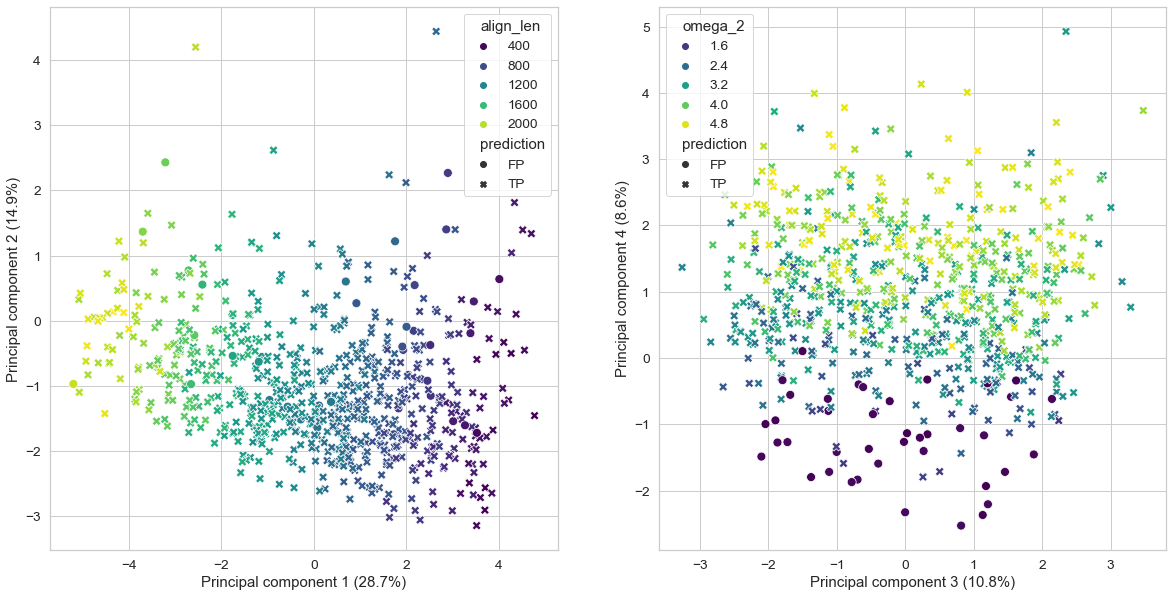

In [418]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

hue_var1, hue_var2 = "align_len", "omega_2"
var1, var2, var3, var4 = pca.explained_variance_ratio_

sns.scatterplot(data=pos_df,
                x="PC1",
                y="PC2",
                style="prediction",
                hue=hue_var1,
                s=80,
                ax=ax[0],
                palette="viridis")
sns.scatterplot(data=pos_df,
                x="PC3",
                y="PC4",
                style="prediction",
                hue=hue_var2,
                s=80,
                ax=ax[1],
                palette="viridis")

ax[0].set_xlabel("Principal component 1 ({0:.1f}%)".format(round(var1,3)*100))
ax[0].set_ylabel("Principal component 2 ({0:.1f}%)".format(round(var2,3)*100))

ax[1].set_xlabel("Principal component 3 ({0:.1f}%)".format(round(var3,3)*100))
ax[1].set_ylabel("Principal component 4 ({0:.1f}%)".format(round(var4,3)*100))

# norm = plt.Normalize(x_df[hue_var].min(), x_df[hue_var].max())
# sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm.set_array([])
# ax.set_ylim(-4.5,4.5)
# ax.set_xlim(-4.5,10.5)
# # Remove the legend and add a colorbar
# # ax.get_legend().remove()
# ax.figure.colorbar(sm,
#                    shrink=.75)

Text(0, 0.5, 'Principal component 2 (13.8%)')

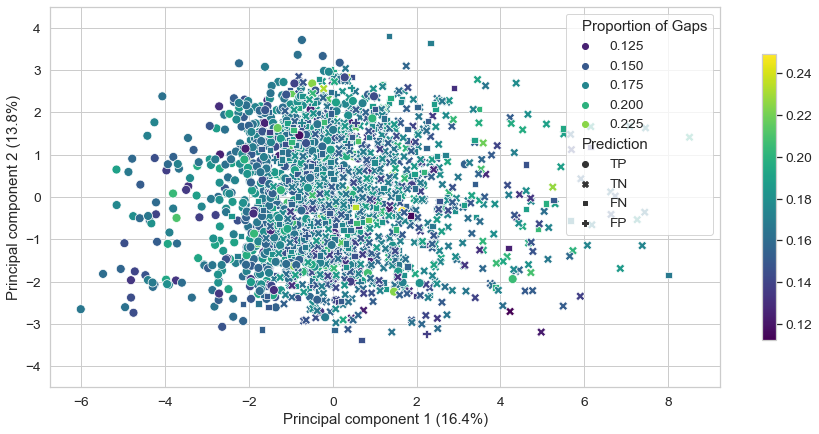

In [122]:
fig, ax = plt.subplots(figsize=(15,7))

hue_var = "info_content"
var1, var2, var3, var4 = pca.explained_variance_ratio_

ax = sns.scatterplot(data=x_df,
                x="PC1",
                y="PC2",
                style="Prediction",
                hue=hue_var,
                s=80,
                palette="viridis")

norm = plt.Normalize(x_df[hue_var].min(), x_df[hue_var].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

ax.set_ylim(-4.5,4.5)
# ax.set_xlim(-4.5,10.5)
# Remove the legend and add a colorbar
# ax.get_legend().remove()
ax.figure.colorbar(sm,
                   shrink=.75)

ax.set_xlabel("Principal component 1 ({0:.1f}%)".format(round(var2,3)*100))
ax.set_ylabel("Principal component 2 ({0:.1f}%)".format(round(var3,3)*100))

In [28]:
ax.get_legend()